In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
#%matplotlib inlineimport

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from scipy.stats import norm, skew, kurtosis

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, widgets, Button, IntSlider, VBox
import math
import tool_1 as t1
#import tool_4 as t4
import edhec_risk_kit as erk
import edhec_cir as ecr
import edhec_riskbudg_optimizer as ero

from pptx import Presentation
from pptx.util import Inches
import tool_6_ppt as t6

import streamlit as st
import pickle

import os

warnings.filterwarnings('ignore')

In [2]:
# Bloomberg daily total return dividend by 100, MSCI Brazil total return USD * BRL 
# df_pr contains daily total returns of 39 Brazilian stocks in 39 columns
file_path = 'br_data_5jul24.xlsx'
sheet_name = 'equ_d'

# Read the Excel file into a pandas DataFrame, specifying the date column as the index
df_pr = pd.read_excel(file_path, sheet_name=sheet_name, header=0, index_col=0)
# Remove weekend rows
df_pr = df_pr[df_pr.index.dayofweek < 5]

# Inspect the first few rows of the DataFrame to understand its structure
#print("First few rows of the DataFrame:")
#print(df_pr.tail())

# Inspect the column names and data types
#print("\nColumn names and data types:")
#print(df_pr.dtypes)

In [3]:
# Convert the index to datetime
df_pr.index = pd.to_datetime(df_pr.index, errors='coerce')

In [4]:
# Check if there are any NaT values in the index
if df_pr.index.isna().any():
    print("There are some values in the index that are not in the datetime format and have been converted to NaT.")
    # Optionally, handle NaT values here, e.g., drop rows with NaT values in the index
    df_pr.dropna(inplace=True)

#print(df_pr.tail())

# Print details of the index
#print("\nIndex details:")
#print(f"Index type: {df_pr.index.dtype}")
#print(f"Index length: {len(df_pr.index)}")
#print(f"First 5 elements of the index:\n{df_pr.index[:5]}")

# Print the shape of the DataFrame
print("\nShape of the DataFrame:")
print(df_pr.shape)


Shape of the DataFrame:
(3569, 38)


In [5]:
# Calculate the Wealth Index (df_pr_wi_d) with a starting value of 100
starting_value = 100
df_pr_wi_d = (1 + df_pr).cumprod() * starting_value

# Calculate the Monthly Wealth Index (resampled to the last value of each month)
df_pr_wi_m = df_pr_wi_d.resample('M').last()

# Calculate Monthly Returns from the Monthly Wealth Index
df_pr_wi_m = df_pr_wi_m.pct_change().dropna()

# Set pandas display option to avoid scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Display the first few rows of the Wealth Index and Monthly Returns
#print("First few rows of the Wealth Index (Daily):")
#print(df_pr_wi_d.head())

#print("\nFirst few rows of the Monthly Returns:")

# Remove "BZ EQUITY" from column names
df_pr_wi_m.columns = df_pr_wi_m.columns.str.replace(' BZ EQUITY', '')

# Calculate the monthly relative performance of PETR4 to VALE3
df_pr_wi_m['PV'] = df_pr_wi_m['PETR4'] - df_pr_wi_m['VALE3']
df_pr_wi_m['PI'] = df_pr_wi_m['PETR4'] - df_pr_wi_m['ITUB4']
df_pr_wi_m['VI'] = df_pr_wi_m['VALE3'] - df_pr_wi_m['ITUB4']
#print(df_pr_wi_m.head())

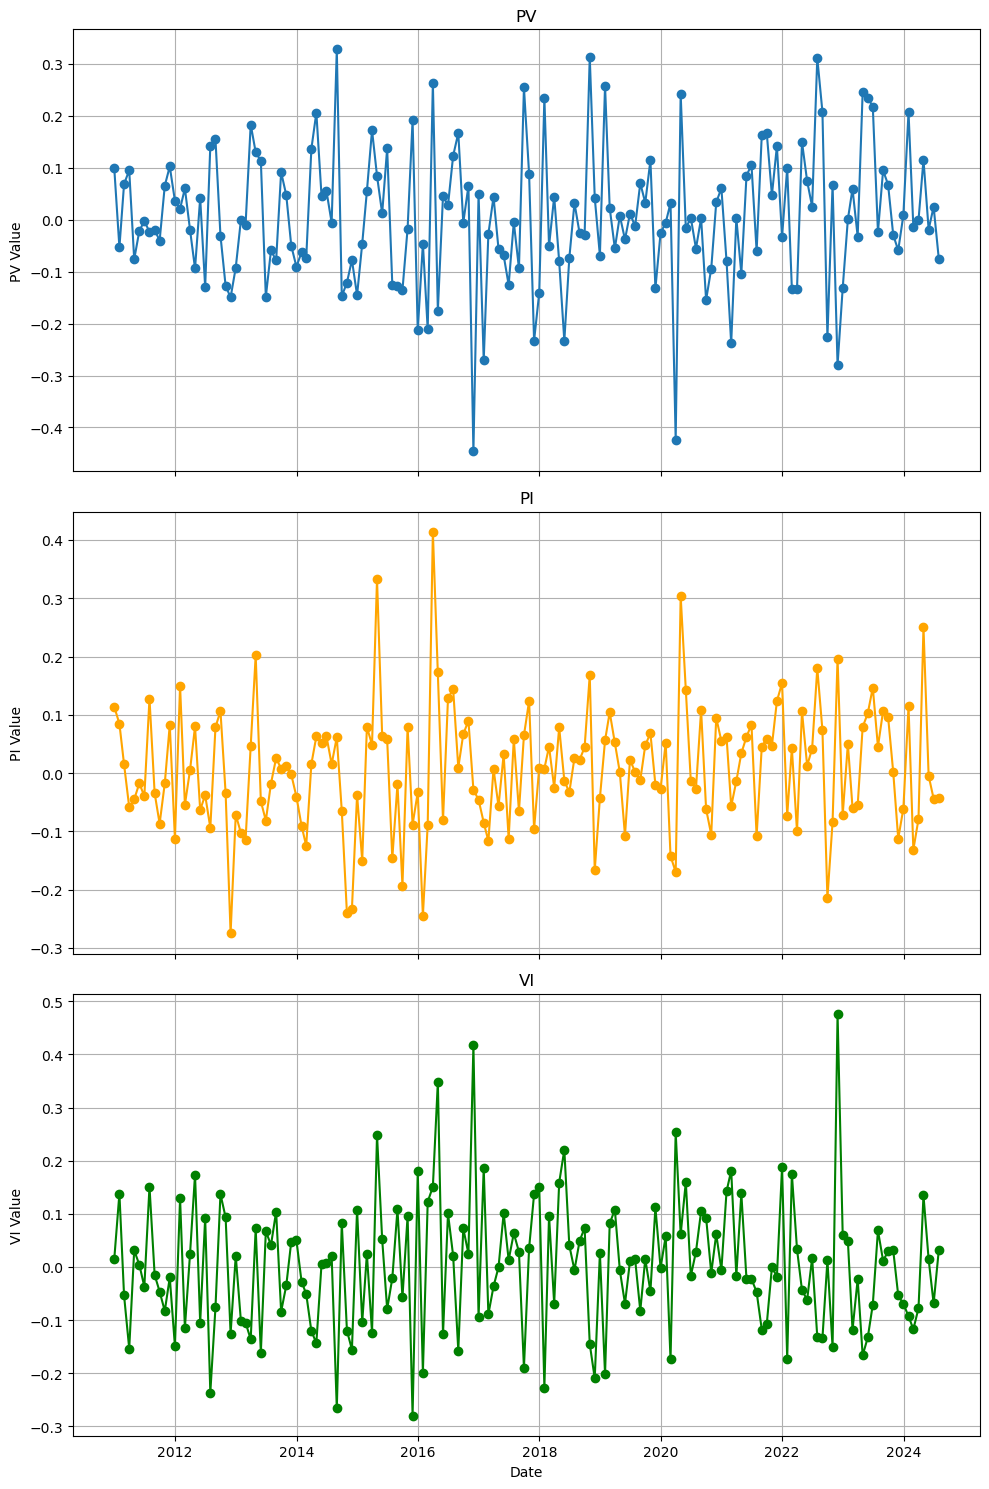

In [6]:
# Plotting the data
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot PV
axs[0].plot(df_pr_wi_m.index, df_pr_wi_m['PV'], marker='o')
axs[0].set_title('PV')
axs[0].set_ylabel('PV Value')
axs[0].grid(True)

# Plot PI
axs[1].plot(df_pr_wi_m.index, df_pr_wi_m['PI'], marker='o', color='orange')
axs[1].set_title('PI')
axs[1].set_ylabel('PI Value')
axs[1].grid(True)

# Plot VI
axs[2].plot(df_pr_wi_m.index, df_pr_wi_m['VI'], marker='o', color='green')
axs[2].set_title('VI')
axs[2].set_ylabel('VI Value')
axs[2].set_xlabel('Date')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [7]:
dw_dep_results = {}
for col in ['PV', 'PI', 'VI']:
    if col in df_pr_wi_m.columns:
        dw_stat = durbin_watson(df_pr_wi_m[col].dropna())
        dw_dep_results[col] = dw_stat

# Create a DataFrame for the results
dw_dep_results_df = pd.DataFrame(list(dw_dep_results.items()), columns=['Series', 'D-W Statistic'])

# Determine the severity of autocorrelation
def determine_severity(dw_stat):
    if dw_stat < 1.5 or dw_stat > 2.5:
        return 'Serious'
    elif 1.5 <= dw_stat <= 2.5:
        return 'None'
    else:
        return 'Mild'

dw_dep_results_df['Severity'] = dw_dep_results_df['D-W Statistic'].apply(determine_severity)

# Display the results
print("\nDurbin-Watson Test Results with Severity:")
print(dw_dep_results_df)


Durbin-Watson Test Results with Severity:
  Series  D-W Statistic Severity
0     PV           2.00     None
1     PI           1.79     None
2     VI           2.32     None


In [8]:
# df_valsize contains price, pe, pb, and mc on last date of 39 stocks in 40 cols
file_path = 'br_data_5jul24.xlsx'
sheet_name = 'ValSize'

# Read the Excel file into a pandas DataFrame, specifying the column headers in the first row
df_valsize_data = pd.read_excel(file_path, sheet_name=sheet_name, header=0)

# Set the first column as index
df_valsize_data.set_index(df_valsize_data.columns[0], inplace=True)

# Display the first few rows of the DataFrame to verify
#print("First few rows of the ValSize DataFrame:")
#print(df_valsize_data.head())

# Print the shape of the DataFrame
#print("\nShape of the ValSize DataFrame:")
#print(df_valsize_data.shape)

In [9]:
# Calculate pe_r = PX_Last / BEST_EPS_MEDIAN
pe_r = df_valsize_data.loc['PX_Last'] / df_valsize_data.loc['BEST_EPS_MEDIAN']

# Calculate pb_r = PX_Last / BOOK_VAL_PER_SH
pb_r = df_valsize_data.loc['PX_Last'] / df_valsize_data.loc['BOOK_VAL_PER_SH']

# Calculate mcap = PX_Last * EQY_SH_OUT
mcap = df_valsize_data.loc['PX_Last'] * df_valsize_data.loc['EQY_SH_OUT']

# Combine the results into a new DataFrame
df_val_size = pd.DataFrame({
    'PE_Ratio': pe_r,
    'PB_Ratio': pb_r,
    'Market_Cap': mcap
})
# Rank the companies based on market cap from lowest to highest
mcap_rank = mcap.rank(method='min')

# Separate the companies into deciles
size_dec = pd.qcut(mcap_rank, 10, labels=False) + 1

# Ensure size_dec is shown as a whole number
size_dec = size_dec.astype(int)

# Set pandas display option to avoid scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Display the results
#print("\nResults DataFrame:")
#print(df_val_size)

In [10]:
# Rank the companies on pe_r and pb_r
pe_r_rank = pe_r.rank(method='min')
pb_r_rank = pb_r.rank(method='min')

# Calculate the average of pe_r and pb_r ranks
value_rank = (pe_r_rank + pb_r_rank) / 2

# Break the sample into deciles
val_dec = pd.qcut(value_rank, 10, labels=False) + 1

# Combine the results into a new DataFrame
df_results = pd.DataFrame({
    'val_dec': val_dec.astype(int),
    'size_dec': size_dec.astype(int),
    'PE_Ratio': pe_r,
    'PB_Ratio': pb_r,
    'PE_Rank': pe_r_rank,
    'PB_Rank': pb_r_rank,
    'Value_Rank': value_rank
})

# Add a row 'Value' to show the decile from 1 to 10
df_results.loc['val_dec'] = df_results['val_dec']

# Set pandas display option to avoid scientific notation
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.float_format', lambda x: '%.0f' % x if x == int(x) else '%.2f' % x)
# Display the results
#print("\nResults DataFrame:")
#print(df_results)

In [11]:
# df_macro contains monthly macro and fin'l index values some differenced, others raw
file_path = 'br_data_5jul24.xlsx'
sheet_name = 'macro'

# Read the Excel file into a pandas DataFrame, specifying the date column as the index
df_macro = pd.read_excel(file_path, sheet_name=sheet_name, header=0, index_col=0)

# Inspect the first few rows of the DataFrame to understand its structure
print("First few rows of the DataFrame:")
print(df_macro.head())

# Inspect the column names and data types
#print("\nColumn names and data types:")
#print(df_macro.dtypes)

First few rows of the DataFrame:
            br_ret_mom  br_ip_mom  br_fdi  br_conconf  br_loans  BRL_ch  \
2009-06-30        7.90       1.30    1689      108.70   1282.92       0   
2009-07-31       -7.40       1.30 2059.20      111.80   1313.53   -0.04   
2009-08-31        2.80       1.60 3017.80      111.70   1333.32    0.01   
2009-09-30        7.50       1.40 2500.20      111.90   1353.11   -0.06   
2009-10-31       -4.50       2.10 1764.50      112.10   1372.24   -0.00   

            BOV_ch  SPY_ch  us_nom5yr  br_yld  us_ret_mom  ch_loans  
2009-06-30    0.30       0       2.55    6.73        0.10   1530.40  
2009-07-31    0.09    0.07       2.51    6.73       -0.10    369.10  
2009-08-31    0.03    0.04       2.38    6.73           0    410.40  
2009-09-30    0.10    0.03       2.31    6.73        0.20    516.70  
2009-10-31    0.12   -0.02       2.31    6.73        0.10       253  


In [12]:
# Convert the index to datetime
df_macro.index = pd.to_datetime(df_macro.index, errors='coerce')

In [13]:
# Check if there are any NaT values in the index
if df_macro.index.isna().any():
    print("There are some values in the index that are not in the datetime format and have been converted to NaT.")
    # Optionally, handle NaT values here, e.g., drop rows with NaT values in the index
    df_macro.dropna(inplace=True)

# Display the first few rows of the DataFrame to verify
#print("First few rows of the DataFrame:")
#print(df_macro.head())

# Print details of the index
#print("\nIndex details:")
#print(f"Index type: {df_macro.index.dtype}")
#print(f"Index length: {len(df_macro.index)}")
print(f"First 5 elements of the index:\n{df_macro.index[:5]}")

# Print the shape of the DataFrame
print("\nShape of the DataFrame:")
print(df_macro.shape)

First 5 elements of the index:
DatetimeIndex(['2009-06-30', '2009-07-31', '2009-08-31', '2009-09-30',
               '2009-10-31'],
              dtype='datetime64[ns]', freq=None)

Shape of the DataFrame:
(181, 12)


In [14]:
print("Column names in the DataFrame:", df_macro.columns)

Column names in the DataFrame: Index(['br_ret_mom', 'br_ip_mom', 'br_fdi', 'br_conconf', 'br_loans', 'BRL_ch',
       'BOV_ch', 'SPY_ch', 'us_nom5yr', 'br_yld', 'us_ret_mom', 'ch_loans'],
      dtype='object')


In [15]:
# Define series that require log transformation, seasonal adjustment, differencing, and standardization

# Select the series that require seasonal adjustment, differencing, and standardization
#seasonal_adjust_diff_std_series = ['br_fdi', 'br_loans', 'us_ret_mom', 'ch_loans']
seasonal_adjust_diff_std_series = ['br_fdi','br_loans', 'us_ret_mom', 'br_loans', 'ch_loans']

# Select the series that require differencing and standardization only
diff_std_series = ['br_conconf', 'us_nom5yr', 'br_yld']

# Select the series that only require standardization
std_only_series = ['br_ret_mom', 'br_ip_mom', 'BRL_ch', 'BOV_ch', 'SPY_ch']

# Initialize a dictionary to store the transformed series
transformed_series = {}

# Small positive number to replace zeros
small_value = 1e-6

# Small positive number to replace zeros
small_value = 1e-6

# Initialize a dictionary to store the transformed series
transformed_series = {}

# Process the series that require seasonal adjustment, differencing, and standardization
for series in seasonal_adjust_diff_std_series:
    if series in df_macro.columns:
        # Seasonal Adjustment
        result = seasonal_decompose(df_macro[series].replace(0, small_value), model='additive', period=12)
        seasonally_adjusted = df_macro[series] - result.seasonal

        # Differencing
        differenced = seasonally_adjusted.diff().dropna()

        # Standardization
        scaler = StandardScaler()
        standardized = scaler.fit_transform(differenced.values.reshape(-1, 1))

        # Store the transformed series
        transformed_series[series] = pd.Series(standardized.flatten(), index=differenced.index)
    else:
        print(f"Column '{series}' not found in the DataFrame.")

# Process the series that require differencing and standardization only
for series in diff_std_series:
    if series in df_macro.columns:
        # Differencing
        differenced = df_macro[series].replace(0, small_value).diff().dropna()

        # Standardization
        scaler = StandardScaler()
        standardized = scaler.fit_transform(differenced.values.reshape(-1, 1))

        # Store the transformed series
        transformed_series[series] = pd.Series(standardized.flatten(), index=differenced.index)
    else:
        print(f"Column '{series}' not found in the DataFrame.")

# Process the series that only require standardization
for series in std_only_series:
    if series in df_macro.columns:
        # Standardization
        scaler = StandardScaler()
        standardized = scaler.fit_transform(df_macro[series].replace(0, small_value).values.reshape(-1, 1))

        # Store the transformed series
        transformed_series[series] = pd.Series(standardized.flatten(), index=df_macro.index)
    else:
        print(f"Column '{series}' not found in the DataFrame.")

# Adding the original BOV series to the transformed_series
if 'BOV_ch' in df_macro.columns:
    transformed_series['BOV'] = df_macro['BOV_ch']

# Combine the transformed series into a DataFrame
transformed_df = pd.DataFrame(transformed_series)

# Display the transformed DataFrame
#print("\nTransformed DataFrame:")
#print(transformed_df.head())
#t1.df_info(transformed_df)

print(transformed_df.head())

            br_fdi  br_loans  us_ret_mom  ch_loans  br_conconf  us_nom5yr  \
2009-06-30     NaN       NaN         NaN       NaN         NaN        NaN   
2009-07-31   -0.34      0.80        0.20     -0.58        0.95      -0.20   
2009-08-31    0.14     -0.85       -0.03     -0.19       -0.00      -0.57   
2009-09-30   -0.10     -0.90        0.11     -0.31        0.09      -0.34   
2009-10-31   -0.39     -0.07       -0.03      0.63        0.09      -0.05   

            br_yld  br_ret_mom  br_ip_mom  BRL_ch  BOV_ch  SPY_ch  BOV  
2009-06-30     NaN        2.28       0.49   -0.15    3.06   -0.25 0.30  
2009-07-31    0.00       -2.26       0.49   -1.15    0.77    1.51 0.09  
2009-08-31    0.00        0.76       0.61    0.03    0.14    0.62 0.03  
2009-09-30    0.00        2.16       0.53   -1.51    0.87    0.47 0.10  
2009-10-31    0.00       -1.40       0.80   -0.23    1.15   -0.71 0.12  


In [16]:
num_columns = transformed_df.shape[1]
print(f'The number of columns in transformed_df is: {num_columns}')

The number of columns in transformed_df is: 13


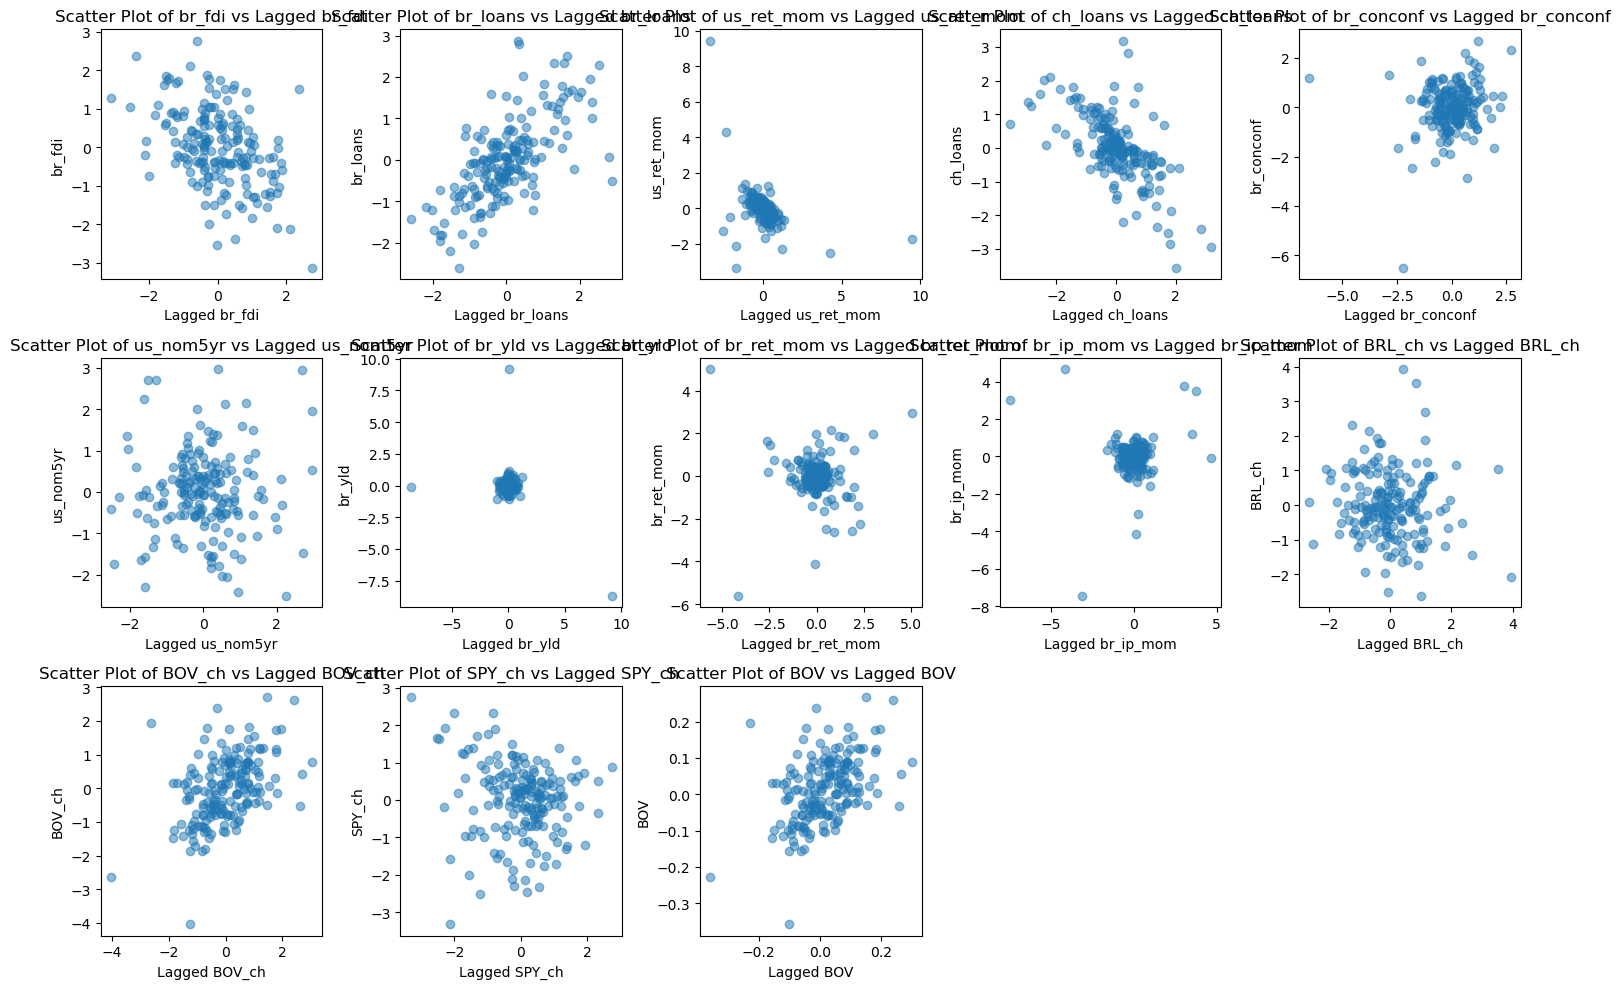

In [17]:
# List of columns to plot
columns_to_plot = transformed_df.columns

# Calculate the number of rows and columns for the subplots
n_rows, n_cols = 3, 5  # 2 rows and 5 columns

# Create the scatterplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    # Plot each variable against its one-period lag
    lagged_data = transformed_df[col].shift(1)
    axes[i].scatter(lagged_data, transformed_df[col], alpha=0.5)
    axes[i].set_title(f'Scatter Plot of {col} vs Lagged {col}')
    axes[i].set_xlabel(f'Lagged {col}')
    axes[i].set_ylabel(col)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
# 'BOV_ch' is standardized, 'BOV' is nonstandardized.  Both are monthly changes.

In [18]:
# Calculate the wealth index for 'BOV' monthly percentage returns
bov_returns = transformed_df['BOV']
wealth_index = (1 + bov_returns).cumprod()

# Align the wealth index with the transformed_df's index
aligned_wealth_index = wealth_index.reindex(transformed_df.index, method='ffill')

# Add the wealth index as a new column 'BOV_for_Beta'
transformed_df['BOV_for_Beta'] = aligned_wealth_index

# Display the transformed DataFrame to verify the new column
print(transformed_df.head())

            br_fdi  br_loans  us_ret_mom  ch_loans  br_conconf  us_nom5yr  \
2009-06-30     NaN       NaN         NaN       NaN         NaN        NaN   
2009-07-31   -0.34      0.80        0.20     -0.58        0.95      -0.20   
2009-08-31    0.14     -0.85       -0.03     -0.19       -0.00      -0.57   
2009-09-30   -0.10     -0.90        0.11     -0.31        0.09      -0.34   
2009-10-31   -0.39     -0.07       -0.03      0.63        0.09      -0.05   

            br_yld  br_ret_mom  br_ip_mom  BRL_ch  BOV_ch  SPY_ch  BOV  \
2009-06-30     NaN        2.28       0.49   -0.15    3.06   -0.25 0.30   
2009-07-31    0.00       -2.26       0.49   -1.15    0.77    1.51 0.09   
2009-08-31    0.00        0.76       0.61    0.03    0.14    0.62 0.03   
2009-09-30    0.00        2.16       0.53   -1.51    0.87    0.47 0.10   
2009-10-31    0.00       -1.40       0.80   -0.23    1.15   -0.71 0.12   

            BOV_for_Beta  
2009-06-30          1.30  
2009-07-31          1.41  
2009-08-31 

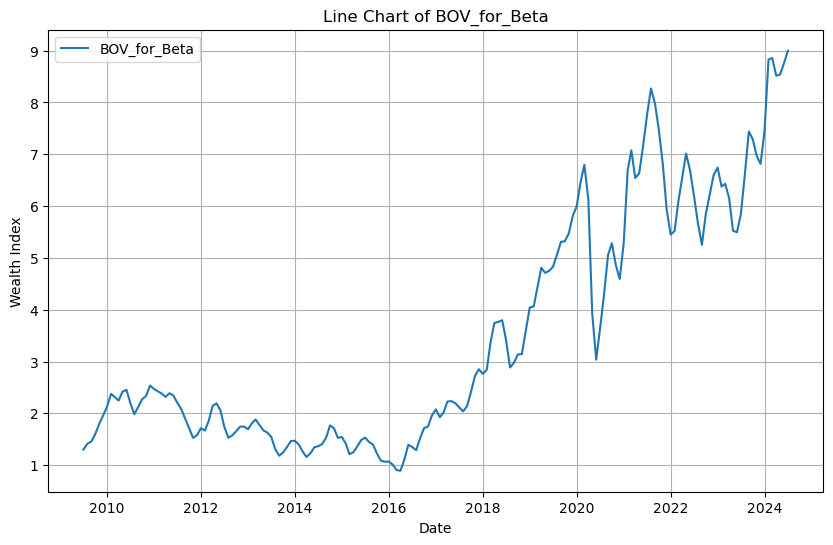

In [19]:
# Plot the line chart for BOV_for_Beta
plt.figure(figsize=(10, 6))
plt.plot(transformed_df.index, transformed_df['BOV_for_Beta'], label='BOV_for_Beta')
plt.title('Line Chart of BOV_for_Beta')
plt.xlabel('Date')
plt.ylabel('Wealth Index')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# List of columns to test
columns_to_test = transformed_df.columns

# Function to determine stationarity based on the D-W statistic
def determine_stationarity(dw_stat):
    if 1.5 < dw_stat < 2.5:
        return 'Yes'
    else:
        return 'No'

# Initialize a list to store the results
results = []

# Perform the D-W test on each column
for col in columns_to_test:
    # Ensure there are no NaN values and the series is not constant
    series = transformed_df[col].dropna()
    
    if series.var() == 0:
        print(f"Series '{col}' is constant; skipping D-W test.")
        continue
    
    if len(series) > 1:
        # Compute the D-W statistic
        dw_stat = durbin_watson(series)
        
        # Determine if the series is stationary
        is_stationary = determine_stationarity(dw_stat)
        
        # Append the results to the list
        results.append({
            'Series': col,
            'D-W Statistic': dw_stat,
            'Stationary': is_stationary
        })
    else:
        print(f"Series '{col}' has insufficient data; skipping D-W test.")

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Set pandas display option to avoid scientific notation
pd.options.display.float_format = '{:.4f}'.format

# Display the results table
print("\nDurbin-Watson Test Results:")
print(results_df)



Durbin-Watson Test Results:
          Series  D-W Statistic Stationary
0         br_fdi         2.8907         No
1       br_loans         0.6569         No
2     us_ret_mom         2.8964         No
3       ch_loans         3.2592         No
4     br_conconf         1.6776        Yes
5      us_nom5yr         1.9698        Yes
6         br_yld         2.8522         No
7     br_ret_mom         2.1071        Yes
8      br_ip_mom         1.9586        Yes
9         BRL_ch         2.1675        Yes
10        BOV_ch         1.0541         No
11        SPY_ch         2.2977        Yes
12           BOV         1.0216         No
13  BOV_for_Beta         0.0078         No


In [21]:
#close to 2 no autocorrelation, close to 0 and 4 fully autocorrelated
#presence of autocorr is expected and should be kept for dependent variables. 

In [22]:
#NEED JOIN TWO DATAFRAMES, RUN GRANGER test

In [23]:
# Extracting the first and last date row from df_pr_wi_m
first_date = df_pr_wi_m.index.min()
last_date = df_pr_wi_m.index.max()
print(first_date)
print(last_date)

2010-12-31 00:00:00
2024-07-31 00:00:00


In [24]:
# Defining the date range for trimming
start_date = pd.to_datetime('2010-12-31')
end_date = pd.to_datetime('2024-06-30')

# Trimming transformed_df
trim_transformed_df = transformed_df[(transformed_df.index >= start_date) & (transformed_df.index <= end_date)]
# Trimming df_pr_wi_m
trim_df_pr_wi_m = df_pr_wi_m[(df_pr_wi_m.index >= start_date) & (df_pr_wi_m.index <= end_date)]
 
print(len(trim_transformed_df))
print(len(trim_df_pr_wi_m))
# Check if trimmed_df and df_pr_wi_m have the same number of rows
same_number_of_rows = len(trim_transformed_df) == len(trim_df_pr_wi_m)

# Output the result
print(f"Do trim_transformed_df and trim_df_pr_wi_m have the same number of rows? {same_number_of_rows}")

163
163
Do trim_transformed_df and trim_df_pr_wi_m have the same number of rows? True


In [25]:
# Joining the dataframes with trimmed_transformed_df on the left
joined_df = trim_transformed_df.join(trim_df_pr_wi_m, how='inner')

# Display the resultant dataframe
t1.df_info(joined_df)

(163, 55)
            br_fdi  br_loans  us_ret_mom  ch_loans  br_conconf  us_nom5yr  \
2010-12-31  2.7678   -1.1088     -0.1803   -0.0031     -0.7134     2.1470   
2011-01-31 -3.1194    0.5762     -0.1904   -1.5301     -0.0007    -0.3057   
2011-02-28  1.2743    0.4777      0.3336    1.4276      0.3260     0.7594   
2011-03-31 -0.6325   -0.7987     -0.1547   -0.8420     -0.7134     0.5199   
2011-04-30  0.3540    0.5656      0.4697    1.2094     -0.5352    -1.2957   

            br_yld  br_ret_mom  br_ip_mom  BRL_ch  ...   TOTS3   EGIE3  \
2010-12-31  0.0031      0.0819     0.1873 -0.8285  ...  0.0441  0.0355   
2011-01-31 -0.0109     -0.2745     0.1493  0.0133  ... -0.0243 -0.0629   
2011-02-28  0.4804      0.5274     0.4153 -0.2922  ... -0.0312  0.0078   
2011-03-31  0.1716      0.1116     0.2253 -0.5668  ... -0.0531  0.0575   
2011-04-30  0.1295     -0.0666    -1.0287 -0.9525  ... -0.0376 -0.0114   

             CSNA3  ENGI11   ENEV3  CPFE3   CPLE6      PV      PI      VI  
2010-1

In [26]:
# List of independent variables and dependent variables
independent_vars = ['br_conconf', 'us_nom5yr', 'br_yld', 'br_ret_mom', 'br_ip_mom', 'BRL_ch', 'BOV_ch', 'SPY_ch', 'br_fdi', 'br_loans', 'us_ret_mom', 'ch_loans']
dependent_vars = ['PV', 'PI', 'VI']

# Function to run Granger causality test
def granger_test(indep_var, dep_var, data):
    max_lag = 1  # Maximum number of lags to check for
    test_result = grangercausalitytests(data[[dep_var, indep_var]], max_lag, verbose=False)
    p_values = [round(test_result[i + 1][0]['ssr_chi2test'][1], 4) for i in range(max_lag)]
    return p_values

# Collecting the results and printing the tables
for dep_var in dependent_vars:
    results = []
    for var in independent_vars:
        p_values = granger_test(var, dep_var, joined_df)  #where dataframe and variables called into granger_test
        is_significant = any(p < 0.05 for p in p_values)
        results.append([var, p_values[0], 'Significant' if is_significant else 'Not Significant'])
    
    results_df = pd.DataFrame(results, columns=['Variable', 'Test Statistic', 'Significance'])
    
    print(f'Granger test for {dep_var}')
    print(results_df)
    print('\n')

Granger test for PV
      Variable  Test Statistic     Significance
0   br_conconf          0.2715  Not Significant
1    us_nom5yr          0.2824  Not Significant
2       br_yld          0.5174  Not Significant
3   br_ret_mom          0.8031  Not Significant
4    br_ip_mom          0.9082  Not Significant
5       BRL_ch          0.9546  Not Significant
6       BOV_ch          0.0219      Significant
7       SPY_ch          0.6260  Not Significant
8       br_fdi          0.3773  Not Significant
9     br_loans          0.0438      Significant
10  us_ret_mom          0.6495  Not Significant
11    ch_loans          0.6587  Not Significant


Granger test for PI
      Variable  Test Statistic     Significance
0   br_conconf          0.7461  Not Significant
1    us_nom5yr          0.2083  Not Significant
2       br_yld          0.7561  Not Significant
3   br_ret_mom          0.0610  Not Significant
4    br_ip_mom          0.2646  Not Significant
5       BRL_ch          0.6893  Not Significan

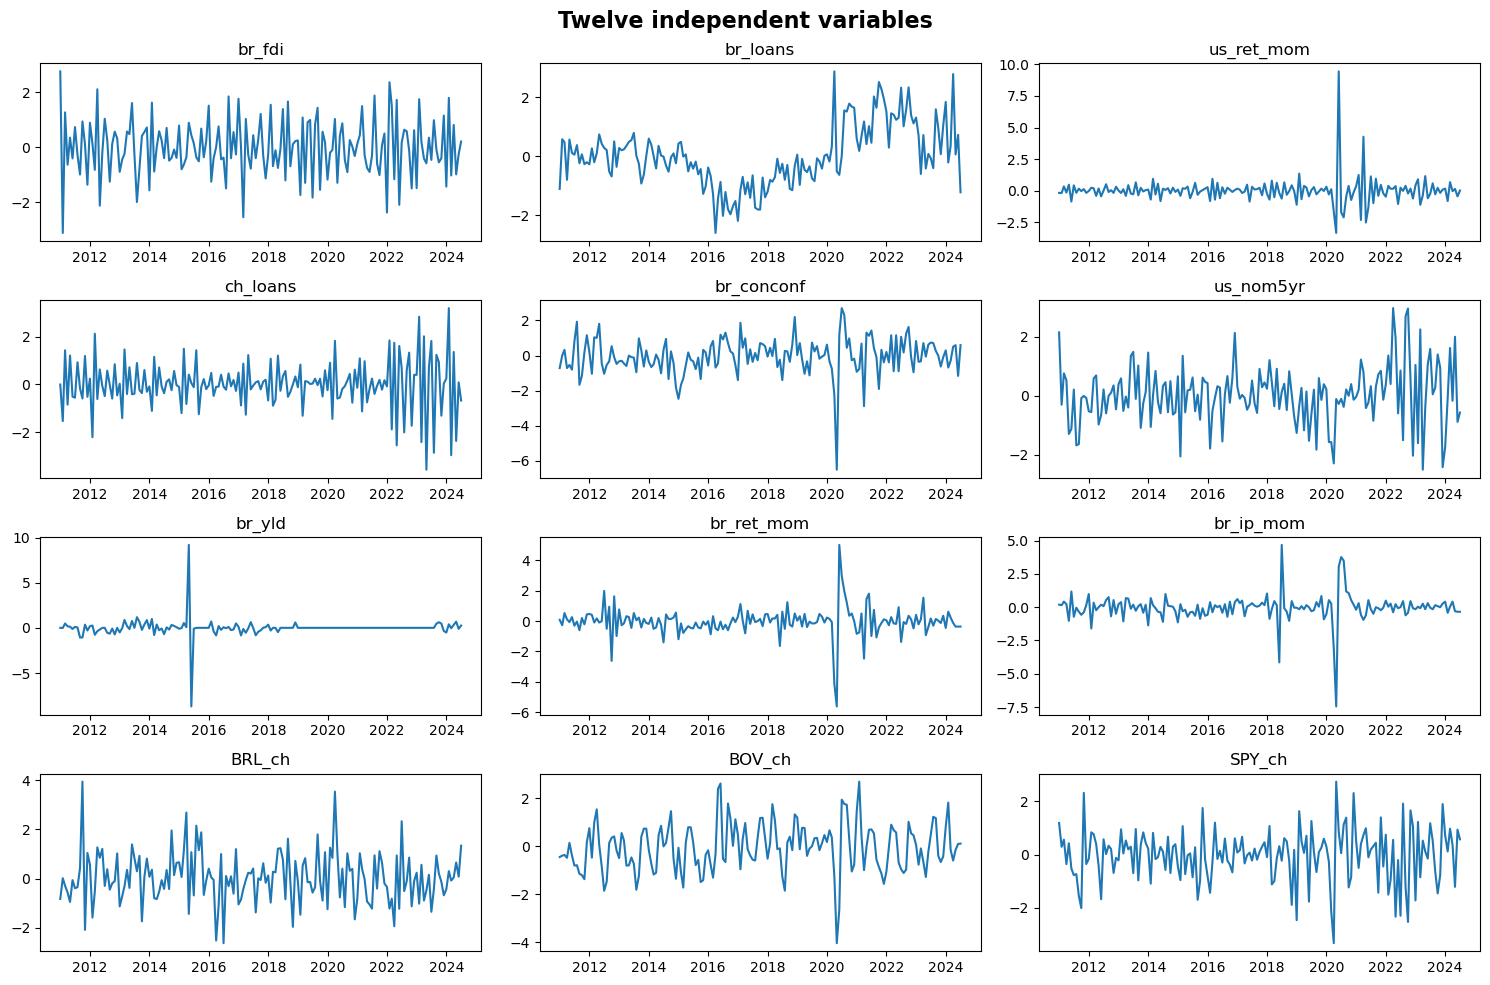

In [27]:
# Select columns 0 to 12
columns_to_plot1 = joined_df.columns[0:12]

# Create a 3x3 subplot
fig, axes = plt.subplots(4, 3, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop to plot each selected column in the DataFrame
for i, col in enumerate(columns_to_plot1):
    axes[i].plot(joined_df.index, joined_df[col])
    axes[i].set_title(col)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a bold title at the top of the multiplot
fig.suptitle('Twelve independent variables', fontsize=16, fontweight='bold')
# Adjust the layout to make room for the title
plt.tight_layout(rect=[0, 0, 1, 1])
# Show plot

# Show plot
plt.show()

In [28]:
def annualize_rets(r, periods_per_year):
    compounded_growth = (1 + r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year / n_periods) - 1

def annualize_vol(r, periods_per_year):
    return r.std() * np.sqrt(periods_per_year)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    rf_per_period = (1 + riskfree_rate)**(1 / periods_per_year) - 1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret / ann_vol

def drawdown(return_series):
    wealth_index = 1000 * (1 + return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, "Peaks": previous_peaks, "Drawdown": drawdowns})

def skewness(r):
    return r.skew()

def kurtosis(r):
    return r.kurt()

def var_gaussian(r, modified=False):
    z = norm.ppf(0.05)
    if modified:
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
             (z**2 - 1) * s / 6 +
             (z**3 - 3 * z) * (k - 3) / 24 -
             (2 * z**3 - 5 * z) * (s**2) / 36
            )
    return -(r.mean() + z * r.std(ddof=0))

def var_historic(r, level=5):
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be Series or DataFrame")

def cvar_historic(r, level=5):
    if isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    elif isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    else:
        raise TypeError("Expected r to be Series or DataFrame")

def beta(returns, benchmark):
    X = add_constant(benchmark)
    model = OLS(returns, X).fit()
    return model.params[1]

def alpha(returns, benchmark, risk_free_rate=0.03):
    X = add_constant(benchmark)
    model = OLS(returns, X).fit()
    return model.params[0] - risk_free_rate

def summary_stats(r, riskfree_rate=0.03, benchmark=None):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    stats_dict = {
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    }
    if benchmark is not None:
        beta_vals = r.apply(lambda x: beta(x, benchmark))
        alpha_vals = r.apply(lambda x: alpha(x, benchmark, riskfree_rate))
        stats_dict["Beta"] = beta_vals
        stats_dict["Alpha"] = alpha_vals
    return pd.DataFrame(stats_dict)

In [29]:
# Extract the relevant series and the benchmark
series_to_analyze = joined_df[['PETR3', 'VALE3', 'ITUB4', 'BOV','PV', 'PI', 'VI']]
benchmark = joined_df['BOV_for_Beta']

# Generate the summary stats table
stats = summary_stats(series_to_analyze, riskfree_rate=0.03, benchmark=benchmark)

# Transpose the DataFrame to switch rows and columns
transposed_stats = stats.T

# Round all data to 3 decimal places
rounded_stats = transposed_stats.round(3)

# Function to bold specified rows
def bold_rows(df, rows_to_bold):
    df_styled = df.style
    for row in rows_to_bold:
        df_styled = df_styled.applymap(lambda x: 'font-weight: bold' if x == row else '', subset=pd.IndexSlice[row, :])
    return df_styled

# Bold 'Annualized Return' and 'Sharpe Ratio' rows
rows_to_bold = ['Annualized Return', 'Sharpe Ratio']
styled_stats = rounded_stats.style.applymap(lambda x: 'font-weight: bold', subset=pd.IndexSlice[rows_to_bold, :])

# Display the styled DataFrame
styled_stats

,PETR3,VALE3,ITUB4,BOV,PV,PI,VI
Annualized Return,0.143000,0.144000,0.147000,0.098000,-0.047000,0.014000,-0.065000
Annualized Vol,0.468000,0.383000,0.304000,0.320000,0.454000,0.367000,0.426000
Skewness,0.419000,0.721000,0.062000,-0.095000,-0.180000,0.351000,0.551000
Kurtosis,2.146000,1.249000,0.539000,1.206000,0.902000,1.447000,1.276000
Cornish-Fisher VaR (5%),0.187000,0.144000,0.131000,0.145000,0.222000,0.159000,0.184000
Historic CVaR (5%),0.240000,0.180000,0.159000,0.173000,0.285000,0.210000,0.221000
Sharpe Ratio,0.234000,0.290000,0.375000,0.206000,-0.166000,-0.042000,-0.217000
Max Drawdown,-0.645000,-0.628000,-0.462000,-0.639000,-0.926000,-0.822000,-0.842000
Beta,0.000000,-0.003000,-0.003000,0.005000,0.003000,0.003000,0.000000
Alpha,-0.011000,-0.002000,-0.003000,-0.035000,-0.037000,-0.035000,-0.029000


In [30]:
# First step to splitting test and Create lags for the target variables (PV, PI, VI) and the macroeconomic variables
lagged_vars = ['PV', 'PI', 'VI', 'br_conconf', 'us_nom5yr', 'br_yld', 'br_ret_mom', 
               'br_ip_mom', 'BRL_ch', 'BOV_ch', 'SPY_ch', 'br_fdi', 'br_loans', 
               'us_ret_mom', 'ch_loans']

# Create a new DataFrame to hold the lagged variables
lagged_df = joined_df[lagged_vars].shift(1).add_suffix('_lag1')

# Combine the original and lagged DataFrames
combined_df = pd.concat([joined_df, lagged_df], axis=1).dropna()

# Display the combined DataFrame
#t1.df_info(combined_df.head())

In [198]:
# The preferred approach is to create a single DataFrame that includes the lagged variables 
#for all predictors and dependent variables. 
#This single DataFrame is then split into one set of training and test data, which can be used for all the target variables (PV, PI, VI). 
#This approach ensures consistency across the different models and target variables.

# Define the predictors (excluding the target variables)
X = combined_df.drop(columns=['PV', 'PI', 'VI'])

# Split the data into training and test sets (e.g., 80% training, 20% testing)
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

# Split the target variables into training and test sets
y_train_PV, y_test_PV = train_test_split(combined_df['PV'], test_size=0.2, shuffle=False)
y_train_PI, y_test_PI = train_test_split(combined_df['PI'], test_size=0.2, shuffle=False)
y_train_VI, y_test_VI = train_test_split(combined_df['VI'], test_size=0.2, shuffle=False)

# Display the shapes to verify the split
print(X_train.shape, X_test.shape, y_train_PV.shape, y_test_PV.shape)
print(y_train_PI.shape, y_test_PI.shape, y_train_VI.shape, y_test_VI.shape)


(129, 67) (33, 67) (129,) (33,)
(129,) (33,) (129,) (33,)


In [199]:
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test)

# Select relevant predictors for each dependent variable from the preprocessed data
predictors_PV = X_train_ols[['const', 'PV_lag1', 'BOV_ch', 'br_loans']]
predictors_PI = X_train_ols[['const', 'PI_lag1', 'BOV_ch', 'br_loans']]
predictors_VI = X_train_ols[['const', 'VI_lag1', 'BOV_ch', 'br_loans']]

# Corresponding test sets
test_predictors_PV = X_test_ols[['const', 'PV_lag1', 'BOV_ch', 'br_loans']]
test_predictors_PI = X_test_ols[['const', 'PI_lag1', 'BOV_ch', 'br_loans']]
test_predictors_VI = X_test_ols[['const', 'VI_lag1', 'BOV_ch', 'br_loans']]

# Fit the OLS model for PV
model_PV = sm.OLS(y_train_PV, predictors_PV).fit()
train_predictions_PV = model_PV.predict(predictors_PV)
test_predictions_PV = model_PV.predict(test_predictors_PV)
predictions_PV = pd.concat([train_predictions_PV, test_predictions_PV])

# Fit the OLS model for PI
model_PI = sm.OLS(y_train_PI, predictors_PI).fit()
train_predictions_PI = model_PI.predict(predictors_PI)
test_predictions_PI = model_PI.predict(test_predictors_PI)
predictions_PI = pd.concat([train_predictions_PI, test_predictions_PI])

# Fit the OLS model for VI
model_VI = sm.OLS(y_train_VI, predictors_VI).fit()
train_predictions_VI = model_VI.predict(predictors_VI)
test_predictions_VI = model_VI.predict(test_predictors_VI)
predictions_VI = pd.concat([train_predictions_VI, test_predictions_VI])

# Evaluate the model for PV
print("PV Model Summary:")
print(model_PV.summary())

# Evaluate the model for PI
print("PI Model Summary:")
print(model_PI.summary())

# Evaluate the model for VI
print("VI Model Summary:")
print(model_VI.summary())


PV Model Summary:
                            OLS Regression Results                            
Dep. Variable:                     PV   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.096
Date:                Sun, 07 Jul 2024   Prob (F-statistic):              0.354
Time:                        05:38:45   Log-Likelihood:                 82.819
No. Observations:                 129   AIC:                            -157.6
Df Residuals:                     125   BIC:                            -146.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0089      0.012  

In [206]:
# New code to create boolean series and calculate wealth index
# Convert predictions to boolean series
bool_series_PV = predictions_PV > 0
bool_series_PI = predictions_PI > 0
bool_series_VI = predictions_VI > 0

# Extract returns series for PETR4, VALE3, ITUB4
returns_PETR4 = df_pr_wi_m['PETR4']
returns_VALE3 = df_pr_wi_m['VALE3']
returns_ITUB4 = df_pr_wi_m['ITUB4']

# Align the boolean series with the returns series
bool_series_PV = bool_series_PV.reindex(returns_PETR4.index, method='ffill').fillna(False)
bool_series_PI = bool_series_PI.reindex(returns_PETR4.index, method='ffill').fillna(False)
bool_series_VI = bool_series_VI.reindex(returns_PETR4.index, method='ffill').fillna(False)

In [207]:
# Calculate wealth indices based on the boolean series
initial_wealth = 100

def calculate_wealth_index(bool_series, returns1, returns2, initial_wealth):
    wealth_index = [initial_wealth]
    for date in bool_series.index[1:]:
        if bool_series[date]:
            wealth_index.append(wealth_index[-1] * (1 + returns1[date]))
        else:
            wealth_index.append(wealth_index[-1] * (1 + returns2[date]))
    return pd.Series(wealth_index, index=bool_series.index)

wealth_index_PV = calculate_wealth_index(bool_series_PV, returns_PETR4, returns_VALE3, initial_wealth)
wealth_index_PI = calculate_wealth_index(bool_series_PI, returns_PETR4, returns_ITUB4, initial_wealth)
wealth_index_VI = calculate_wealth_index(bool_series_VI, returns_VALE3, returns_ITUB4, initial_wealth)

In [210]:
# Create a dataframe to store the wealth indices
WI_new = pd.DataFrame({
    'Wealth_Index_PV': wealth_index_PV,
    'Wealth_Index_PI': wealth_index_PI,
    'Wealth_Index_VI': wealth_index_VI
})

In [211]:
# Display the first few rows to verify
print(WI_new.head())

            Wealth_Index_PV  Wealth_Index_PI  Wealth_Index_VI
                                                             
2010-12-31         100.0000         100.0000         100.0000
2011-01-31         104.4146         104.4146         104.4146
2011-02-28         102.9878         102.9878         102.9878
2011-03-31         104.1493         104.1493         104.1493
2011-04-30         106.0608         106.0608          98.1159


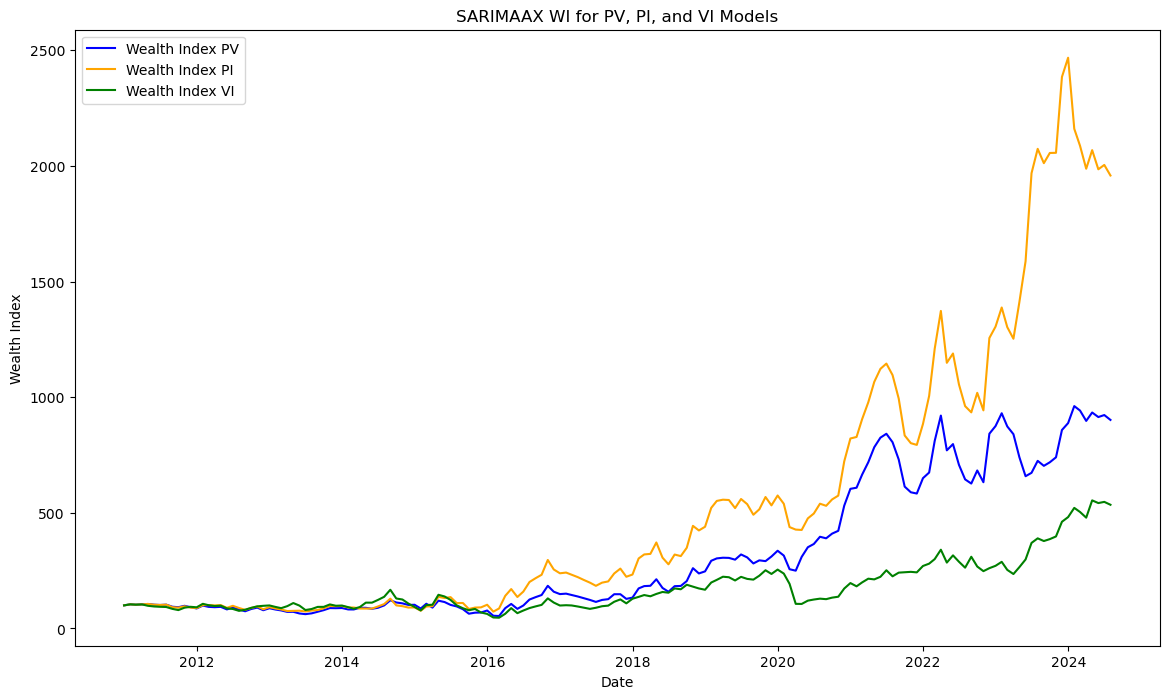

In [253]:
# Plot the wealth indices
plt.figure(figsize=(14, 8))

plt.plot(WI_new.index, WI_new['Wealth_Index_PV'], label='Wealth Index PV', color='blue')
plt.plot(WI_new.index, WI_new['Wealth_Index_PI'], label='Wealth Index PI', color='orange')
plt.plot(WI_new.index, WI_new['Wealth_Index_VI'], label='Wealth Index VI', color='green')

# Add title and labels
plt.title('SARIMAX WI for PV, PI, and VI Models')
plt.xlabel('Date')
plt.ylabel('Wealth Index')
plt.legend()

# Show the plot
plt.show()

In [295]:
# Initialize a new DataFrame to store results
test_comp = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE'])

# Function to calculate statistics
def calculate_statistics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Function to add model statistics to the DataFrame
def add_model_statistics(model_ref, y_true, y_pred):
    mae, rmse, mape = calculate_statistics(y_true, y_pred)
    formatted_mae = f"{mae:.2f}"
    formatted_rmse = f"{rmse:.2f}"
    formatted_mape = f"{mape:.0f}"
    # Append results to the existing test_comp DataFrame
    
    global test_comp
    new_row = pd.DataFrame({'Model': [model_ref], 'MAE': [formatted_mae], 'RMSE': [formatted_rmse], 'MAPE': [formatted_mape]})
    test_comp = pd.concat([test_comp, new_row], ignore_index=True)
    print(f"Added {model_ref} statistics to the DataFrame.")
    
# Display the initial DataFrame
print(test_comp)

Empty DataFrame
Columns: [Model, MAE, RMSE, MAPE]
Index: []


In [296]:
# Add the OLS statistics to the test_comp DataFrame
add_model_statistics('PV_s', y_test_PV, test_predictions_PV)
add_model_statistics('PI_s', y_test_PI, test_predictions_PI)
add_model_statistics('VI_s', y_test_VI, test_predictions_VI)

Added PV_s statistics to the DataFrame.
Added PI_s statistics to the DataFrame.
Added VI_s statistics to the DataFrame.


In [297]:
# Display the updated DataFrame
print(test_comp)

  Model   MAE  RMSE MAPE
0  PV_s  0.12  0.15  360
1  PI_s  0.10  0.12  124
2  VI_s  0.10  0.13  192


In [126]:
# Define the function to format the OLS equation
def format_ols_equation(model):
    equation = f"y = {model.params[0]:.4f}"  # Intercept
    for i, coef in enumerate(model.params[1:], start=1):
        equation += f" + ({coef:.4f})*x{i}"
    return equation

# Extract and format the OLS equations for PV, PI, and VI
models = {
    'PV': (model_PV, 'PV_lag1'),
    'PI': (model_PI, 'PI_lag1'),
    'VI': (model_VI, 'VI_lag1')
}

# Extract coefficients for impact values
x2 = model_PV.params['BOV_ch']
x3 = model_PV.params['br_loans']

# Iteratively process each model
for key, (model, lag_name) in models.items():
    # Format the OLS equation
    equation = format_ols_equation(model)
    
    # Print the OLS equation
    print(f"Equation for {key}: {equation}")
    
    # Extract the specific impact value for x1
    impact_value_x1 = model.params[lag_name]
    
    # Print the variable relationships
    if key == 'PV':
        print(f"x1 = PVt-1/PVt-2")
    elif key == 'PI':
        print(f"x1 = PIt-1/PIt-2")
    else:  # For VI
        print(f"x1 = VIt-1/VIt-2")
    print(f"x2 = Bovespat-1/t-2")
    print(f"x3 = Brazil loans t-1/t-2 (seasonally adjusted)")
    
    # Construct and print the impact message
    impact_message = (f"A 1% increase in previous month's change in {key} has a {impact_value_x1 / 100:.4f} percentage impact, "
                      f"a 1% increase in the previous month's change in the Bovespa Index has a {x2 / 100:.4f} impact, "
                      f"a 1% increase in previous month's seasonally adjusted change in Brazilian loans has a {x3 / 100:.4f} impact.")
    
    print(impact_message)
    print()  # Blank line for better readability


Equation for PV: y = -0.0089 + (-0.0601)*x1 + (0.0033)*x2 + (-0.0201)*x3
x1 = PVt-1/PVt-2
x2 = Bovespat-1/t-2
x3 = Brazil loans t-1/t-2 (seasonally adjusted)
A 1% increase in previous month's change in PV has a -0.0006 percentage impact, a 1% increase in the previous month's change in the Bovespa Index has a 0.0000 impact, a 1% increase in previous month's seasonally adjusted change in Brazilian loans has a -0.0002 impact.

Equation for PI: y = -0.0041 + (0.1175)*x1 + (-0.0015)*x2 + (-0.0224)*x3
x1 = PIt-1/PIt-2
x2 = Bovespat-1/t-2
x3 = Brazil loans t-1/t-2 (seasonally adjusted)
A 1% increase in previous month's change in PI has a 0.0012 percentage impact, a 1% increase in the previous month's change in the Bovespa Index has a 0.0000 impact, a 1% increase in previous month's seasonally adjusted change in Brazilian loans has a -0.0002 impact.

Equation for VI: y = 0.0054 + (-0.1883)*x1 + (0.0018)*x2 + (-0.0052)*x3
x1 = VIt-1/VIt-2
x2 = Bovespat-1/t-2
x3 = Brazil loans t-1/t-2 (seasonall

In [331]:
# Function to apply RFE and print feature rankings. Must use RandomForestRegressor not Classifier
# since dependent variable is continuous.  Originally, I did Classifier and looked for 1s and 0s
# Define the predictors (only _lag1 variables, excluding the target variables)

lag1_columns = [col for col in combined_df.columns if '_lag1' in col]
X = combined_df[lag1_columns]

# Split the data into training and test sets (e.g., 80% training, 20% testing)
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

# Split the target variables into training and test sets
y_train_PV, y_test_PV = train_test_split(combined_df['PV'], test_size=0.2, shuffle=False)
y_train_PI, y_test_PI = train_test_split(combined_df['PI'], test_size=0.2, shuffle=False)
y_train_VI, y_test_VI = train_test_split(combined_df['VI'], test_size=0.2, shuffle=False)

# Filter the data to include only the lagged features used in RFE
X_train_lagged = X_train[lag1_columns]
X_test_lagged = X_test[lag1_columns]

# Scale the training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lagged)
X_test_scaled = scaler.transform(X_test_lagged)

# Save the scaler to a file
with open('scaler_knn.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [240]:
# Function to apply RFE and print feature rankings
def apply_rfe_and_print(X_train_scaled, y_train, target_name, n_features_to_select=3, features=(1, 2, 3)):
    rf = RandomForestRegressor()
    rfe = RFE(estimator=rf, n_features_to_select=n_features_to_select)
    rfe.fit(X_train_scaled, y_train)
    
    feature_ranking = sorted(zip(rfe.ranking_, lag1_columns))
    print(f"Feature ranking for {target_name} (1=most important):")
    for rank, feature in feature_ranking:
        print(f"{feature}: {rank}")
    
    top_features = [feature for rank, feature in feature_ranking if rank in features]
    print(f"Top features for {target_name}: {top_features}")
    return rfe, top_features

# Apply RFE for PV, PI, and VI
rfe_PV, top_features_PV = apply_rfe_and_print(X_train_scaled, y_train_PV, "PV")
rfe_PI, top_features_PI = apply_rfe_and_print(X_train_scaled, y_train_PI, "PI")
rfe_VI, top_features_VI = apply_rfe_and_print(X_train_scaled, y_train_VI, "VI")

Feature ranking for PV (1=most important):
PI_lag1: 1
SPY_ch_lag1: 1
br_loans_lag1: 1
BOV_ch_lag1: 2
VI_lag1: 3
us_nom5yr_lag1: 4
ch_loans_lag1: 5
br_conconf_lag1: 6
BRL_ch_lag1: 7
br_ip_mom_lag1: 8
PV_lag1: 9
us_ret_mom_lag1: 10
br_fdi_lag1: 11
br_ret_mom_lag1: 12
br_yld_lag1: 13
Top features for PV: ['PI_lag1', 'SPY_ch_lag1', 'br_loans_lag1', 'BOV_ch_lag1', 'VI_lag1']
Feature ranking for PI (1=most important):
BRL_ch_lag1: 1
PV_lag1: 1
SPY_ch_lag1: 1
BOV_ch_lag1: 2
br_loans_lag1: 3
us_ret_mom_lag1: 4
VI_lag1: 5
br_ip_mom_lag1: 6
us_nom5yr_lag1: 7
br_ret_mom_lag1: 8
PI_lag1: 9
ch_loans_lag1: 10
br_conconf_lag1: 11
br_yld_lag1: 12
br_fdi_lag1: 13
Top features for PI: ['BRL_ch_lag1', 'PV_lag1', 'SPY_ch_lag1', 'BOV_ch_lag1', 'br_loans_lag1']
Feature ranking for VI (1=most important):
PV_lag1: 1
br_loans_lag1: 1
us_ret_mom_lag1: 1
PI_lag1: 2
SPY_ch_lag1: 3
br_conconf_lag1: 4
VI_lag1: 5
BOV_ch_lag1: 6
BRL_ch_lag1: 7
us_nom5yr_lag1: 8
br_fdi_lag1: 9
ch_loans_lag1: 10
br_ip_mom_lag1: 11
br_y

In [289]:
# Function to calculate statistics
def calculate_statistics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

In [298]:
# Function to fit k-NN model and calculate statistics using selected features
def fit_knn_and_evaluate(X_train_scaled, X_test_scaled, y_train, y_test, rfe, model_ref):
    selected_features_mask = [rank in (1, 2, 3) for rank in rfe.ranking_]
    X_train_top = X_train_scaled[:, selected_features_mask]
    X_test_top = X_test_scaled[:, selected_features_mask]

    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train_top, y_train)
    y_pred = knn.predict(X_test_top)

    mae, rmse, mape = calculate_statistics(y_test, y_pred)
    formatted_mae = f"{mae:.2f}"
    formatted_rmse = f"{rmse:.2f}"
    formatted_mape = f"{mape:.0f}"
    
    global test_comp
    if 'test_comp' not in globals():
        test_comp = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE'])
    
    new_row = pd.DataFrame({'Model': [model_ref], 'MAE': [formatted_mae], 'RMSE': [formatted_rmse], 'MAPE': [formatted_mape]})
    test_comp = pd.concat([test_comp, new_row], ignore_index=True)
    
    selected_features = np.array(lag1_columns)[selected_features_mask]
    print(f"Selected features for {model_ref}: {selected_features}")
    
    return knn, selected_features_mask, pd.Series(y_pred, index=y_test.index)

def remove_duplicates(df, column):
    """
    Remove duplicate rows from the DataFrame based on the specified column.

    Parameters:
    df (pd.DataFrame): The DataFrame to remove duplicates from.
    column (str): The column to check for duplicates.

    Returns:
    pd.DataFrame: The DataFrame with duplicates removed.
    """
    return df.drop_duplicates(subset=column, keep='last')

# Example usage for cleaning the test_comp DataFrame
test_comp = remove_duplicates(test_comp, 'Model')

# Fit and evaluate k-NN for PV
knn_PV, features_mask_PV, predictions_PV_k = fit_knn_and_evaluate(X_train_scaled, X_test_scaled, y_train_PV, y_test_PV, rfe_PV, 'PV_k')

# Fit and evaluate k-NN for PI
knn_PI, features_mask_PI, predictions_PI_k = fit_knn_and_evaluate(X_train_scaled, X_test_scaled, y_train_PI, y_test_PI, rfe_PI, 'PI_k')

# Fit and evaluate k-NN for VI
knn_VI, features_mask_VI, predictions_VI_k = fit_knn_and_evaluate(X_train_scaled, X_test_scaled, y_train_VI, y_test_VI, rfe_VI, 'VI_k')

Selected features for PV_k: ['PI_lag1' 'VI_lag1' 'BOV_ch_lag1' 'SPY_ch_lag1' 'br_loans_lag1']
Selected features for PI_k: ['PV_lag1' 'BRL_ch_lag1' 'BOV_ch_lag1' 'SPY_ch_lag1' 'br_loans_lag1']
Selected features for VI_k: ['PV_lag1' 'PI_lag1' 'SPY_ch_lag1' 'br_loans_lag1' 'us_ret_mom_lag1']


In [299]:
# Display the updated DataFrame
print(test_comp)

  Model   MAE  RMSE MAPE
0  PV_s  0.12  0.15  360
1  PI_s  0.10  0.12  124
2  VI_s  0.10  0.13  192
3  PV_k  0.10  0.14  562
4  PI_k  0.08  0.10  164
5  VI_k  0.10  0.15  208


In [243]:
# Combine training and test data for predictors and target variables
X_combined = pd.concat([X_train_lagged, X_test_lagged])
y_combined_PV = pd.concat([y_train_PV, y_test_PV])
y_combined_PI = pd.concat([y_train_PI, y_test_PI])
y_combined_VI = pd.concat([y_train_VI, y_test_VI])

# Scale the combined data
X_combined_scaled = scaler.transform(X_combined)

# Generate predictions over the combined scaled dataset
predictions_PV_k_combined = knn_PV.predict(X_combined_scaled[:, features_mask_PV])
predictions_PI_k_combined = knn_PI.predict(X_combined_scaled[:, features_mask_PI])
predictions_VI_k_combined = knn_VI.predict(X_combined_scaled[:, features_mask_VI])

# Convert predictions to boolean series
bool_series_PV_k = predictions_PV_k_combined > 0
bool_series_PI_k = predictions_PI_k_combined > 0
bool_series_VI_k = predictions_VI_k_combined > 0

In [245]:
# Extract returns series for PETR4 and VALE3
returns_PETR4 = df_pr_wi_m['PETR4']
returns_VALE3 = df_pr_wi_m['VALE3']
returns_ITUB4 = df_pr_wi_m['ITUB4']
# Align the boolean series with the returns series
bool_series_PV_k = pd.Series(bool_series_PV_k, index=y_combined_PV.index).reindex(returns_PETR4.index, method='ffill').fillna(False)
bool_series_PI_k = pd.Series(bool_series_PI_k, index=y_combined_PI.index).reindex(returns_PETR4.index, method='ffill').fillna(False)
bool_series_VI_k = pd.Series(bool_series_VI_k, index=y_combined_VI.index).reindex(returns_PETR4.index, method='ffill').fillna(False)


In [247]:
# Calculate wealth indices based on the boolean series
initial_wealth = 100

def calculate_wealth_index(bool_series, returns1, returns2, initial_wealth):
    wealth_index = [initial_wealth]
    for date in bool_series.index[1:]:
        if bool_series[date]:
            wealth_index.append(wealth_index[-1] * (1 + returns1[date]))
        else:
            wealth_index.append(wealth_index[-1] * (1 + returns2[date]))
    return pd.Series(wealth_index, index=bool_series.index)

wealth_index_PV_k = calculate_wealth_index(bool_series_PV_k, returns_PETR4, returns_VALE3, initial_wealth)
wealth_index_PI_k = calculate_wealth_index(bool_series_PI_k, returns_PETR4, returns_VALE3, initial_wealth)
wealth_index_VI_k = calculate_wealth_index(bool_series_VI_k, returns_PETR4, returns_VALE3, initial_wealth)

# Create a dataframe to store the wealth indices
WI_k = pd.DataFrame({
    'Wealth_Index_PV_k': wealth_index_PV_k,
    'Wealth_Index_PI_k': wealth_index_PI_k,
    'Wealth_Index_VI_k': wealth_index_VI_k
})

# Display the first few rows to verify
print(WI_k.head())

            Wealth_Index_PV_k  Wealth_Index_PI_k  Wealth_Index_VI_k
                                                                   
2010-12-31           100.0000           100.0000           100.0000
2011-01-31            99.0837            99.0837            99.0837
2011-02-28            97.7297            97.7297           104.5336
2011-03-31            98.8319            89.5264           105.7125
2011-04-30           100.6459            91.1695            99.5886


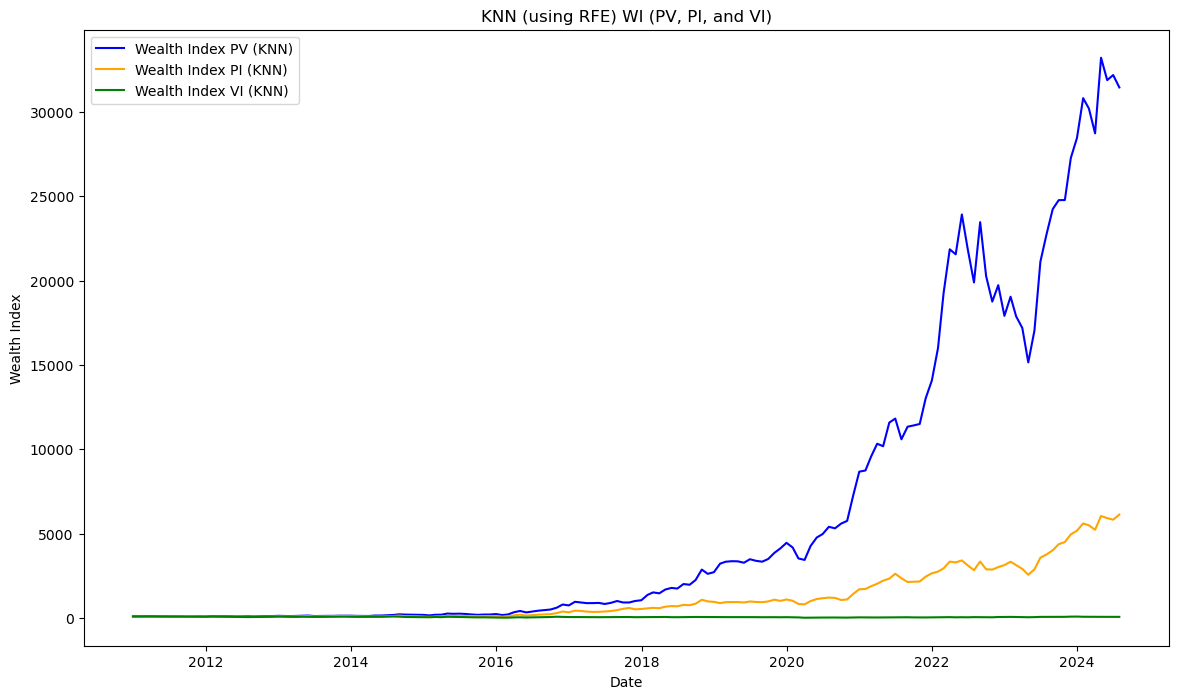

In [254]:
# Plot the wealth indices
plt.figure(figsize=(14, 8))

plt.plot(WI_k.index, WI_k['Wealth_Index_PV_k'], label='Wealth Index PV (KNN)', color='blue')
plt.plot(WI_k.index, WI_k['Wealth_Index_PI_k'], label='Wealth Index PI (KNN)', color='orange')
plt.plot(WI_k.index, WI_k['Wealth_Index_VI_k'], label='Wealth Index VI (KNN)', color='green')

# Add title and labels
plt.title('KNN (using RFE) WI (PV, PI, and VI)')
plt.xlabel('Date')
plt.ylabel('Wealth Index')
plt.legend()

# Show the plot
plt.show()

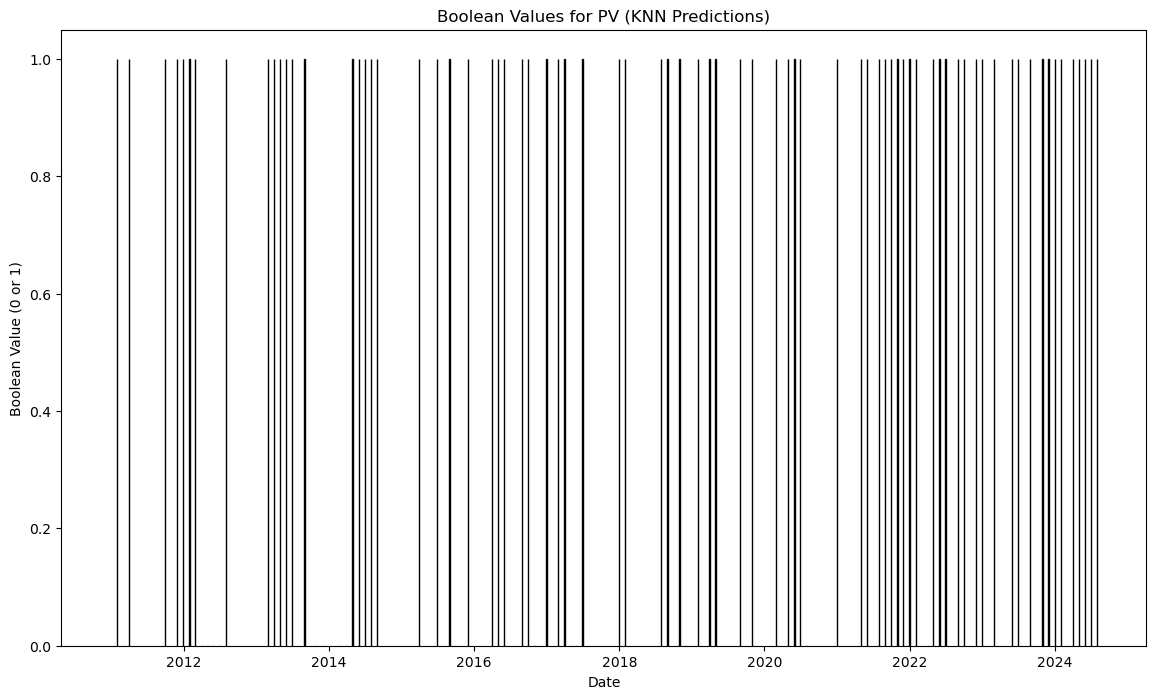

In [252]:
# Convert the boolean series to integers for visualization
#bool_series_PV_k_int = bool_series_PV_k.astype(int)

# Plot the bar chart
#plt.figure(figsize=(14, 8))
#plt.bar(bool_series_PV_k_int.index, bool_series_PV_k_int, width=1.0, edgecolor='black')

# Add title and labels
#plt.title('Boolean Values for PV (KNN Predictions)')
#plt.xlabel('Date')
#plt.ylabel('Boolean Value (0 or 1)')

# Show the plot
#plt.show()

In [251]:
# Set the option to display all rows
#pd.set_option('display.max_rows', None)

# Print the entire Wealth_Index_PV_k
#print(wealth_index_PV_k)

# Reset the option if needed (optional)
#pd.reset_option('display.max_rows')

In [41]:
# Extract key metrics
#accuracy = report['accuracy']
#precision_0 = report['0']['precision']
#recall_0 = report['0']['recall']
#precision_1 = report['1']['precision']
#recall_1 = report['1']['recall']

# Print concise bullet points
#print(f"• Model accuracy - or hitrit is expressed in decimal form: {accuracy:.2f}")
#print(f"• Precision for nonpositive PV: {precision_0:.2f}, Recall for nonpositive PV: {recall_0:.2f}")
#print(f"• Precision for positive PV: {precision_1:.2f}, Recall for positive PV: {recall_1:.2f}")
#print('precision: share identifies instances / recall: share not missed')

In [42]:
#method 3: Long Short-term memory (LSTM) ideally suited for
#for temporal dependencies in time series models. Use RFE for selection (removed this step 6July24)
#use same test/train, same RFE, but need to reshape into 3-dimensional
# shape. need add required 1 time step dimension.

In [43]:
# Define the lag1 columns
lag1_columns = [col for col in combined_df.columns if '_lag1' in col]
X = combined_df[lag1_columns]

# Split the data into training and test sets (e.g., 80% training, 20% testing)
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

# Split the target variables into training and test sets
y_train_PV, y_test_PV = train_test_split(combined_df['PV'], test_size=0.2, shuffle=False)
y_train_PI, y_test_PI = train_test_split(combined_df['PI'], test_size=0.2, shuffle=False)
y_train_VI, y_test_VI = train_test_split(combined_df['VI'], test_size=0.2, shuffle=False)

# Display the shapes to verify the split
print(X_train.shape, X_test.shape, y_train_PV.shape, y_test_PV.shape)
print(y_train_PI.shape, y_test_PI.shape, y_train_VI.shape, y_test_VI.shape)


(129, 15) (33, 15) (129,) (33,)
(129,) (33,) (129,) (33,)


In [44]:
# Scale the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify the shapes after scaling
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (129, 15)
X_test_scaled shape: (33, 15)


In [45]:
def prepare_lstm_data(X_scaled):
    # Reshape data for LSTM: [samples, time steps, features]
    X_lstm = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))
    return X_lstm

# Prepare training and test data for LSTM using existing datasets
X_train_lstm = prepare_lstm_data(X_train_scaled)
X_test_lstm = prepare_lstm_data(X_test_scaled)

# Verify the shapes after reshaping
print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"X_test_lstm shape: {X_test_lstm.shape}")


X_train_lstm shape: (129, 1, 15)
X_test_lstm shape: (33, 1, 15)


In [300]:
# Function to calculate statistics
def calculate_statistics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Function to build and train the LSTM model
def build_and_train_lstm(X_train, y_train, X_test, y_test, model_ref, feature_names):
    # Ensure the feature names match the columns used in training/testing sets
    print(f"Features used: {feature_names}")
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate test statistics
    mae, rmse, mape = calculate_statistics(y_test, y_pred)
    formatted_mae = f"{mae:.2f}"
    formatted_rmse = f"{rmse:.2f}"
    formatted_mape = f"{mape:.0f}"
    
    global test_comp
    if 'test_comp' not in globals():
        test_comp = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE'])
    
    new_row = pd.DataFrame({'Model': [model_ref], 'MAE': [formatted_mae], 'RMSE': [formatted_rmse], 'MAPE': [formatted_mape]})
    test_comp = pd.concat([test_comp, new_row], ignore_index=True)

    print(f"Model {model_ref} - Evaluation Metrics: MAE={formatted_mae}, RMSE={formatted_rmse}, MAPE={formatted_mape}")

    return y_pred
# Train and evaluate LSTM model for PV
predictions_PV_l = build_and_train_lstm(X_train_lstm, y_train_PV.values, X_test_lstm, y_test_PV.values, 'PV_l', lag1_columns)

# Train and evaluate LSTM model for PI
predictions_PI_l = build_and_train_lstm(X_train_lstm, y_train_PI.values, X_test_lstm, y_test_PI.values, 'PI_l', lag1_columns)

# Train and evaluate LSTM model for VI
predictions_VI_l = build_and_train_lstm(X_train_lstm, y_train_VI.values, X_test_lstm, y_test_VI.values, 'VI_l', lag1_columns)

# Display the updated DataFrame
print(test_comp)


Features used: ['PV_lag1', 'PI_lag1', 'VI_lag1', 'br_conconf_lag1', 'us_nom5yr_lag1', 'br_yld_lag1', 'br_ret_mom_lag1', 'br_ip_mom_lag1', 'BRL_ch_lag1', 'BOV_ch_lag1', 'SPY_ch_lag1', 'br_fdi_lag1', 'br_loans_lag1', 'us_ret_mom_lag1', 'ch_loans_lag1']
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Model PV_l - Evaluation Metrics: MAE=0.15, RMSE=0.19, MAPE=1206
Features used: ['PV_lag1', 'PI_lag1', 'VI_lag1', 'br_conconf_lag1', 'us_nom5yr_lag1', 'br_yld_lag1', 'br_ret_mom_lag1', 'br_ip_mom_lag1', 'BRL_ch_lag1', 'BOV_ch_lag1', 'SPY_ch_lag1', 'br_fdi_lag1', 'br_loans_lag1', 'us_ret_mom_lag1', 'ch_loans_lag1']
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Model PI_l - Evaluation Metrics: MAE=0.12, RMSE=0.15, MAPE=433
Features used: ['PV_lag1', 'PI_lag1', 'VI_lag1', 'br_conconf_lag1', 'us_nom5yr_lag1', 'br_yld_lag1', 'br_ret_mom_lag1', 'br_ip_mom_lag1', 'BRL_ch_lag1', 'BOV_ch_lag1', 'SPY_ch_lag1', 'br_fdi_lag1', 'br_loans_lag1', 'us_ret_mom_lag1', 'ch_loans_lag1']
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Mod

In [345]:
#heatmap got lost somewhere


In [255]:
# PINK: Combine training and test data for predictors and target variables
X_combined = pd.concat([X_train, X_test])
y_combined_PV = pd.concat([y_train_PV, y_test_PV])
y_combined_PI = pd.concat([y_train_PI, y_test_PI])
y_combined_VI = pd.concat([y_train_VI, y_test_VI])

# PINK: Scale the combined data
scaler_combined = StandardScaler()
X_combined_scaled = scaler_combined.fit_transform(X_combined)

# PINK: Prepare data for LSTM models
X_combined_lstm = X_combined_scaled.reshape((X_combined_scaled.shape[0], 1, X_combined_scaled.shape[1]))


In [256]:
# PINK: Function to build and train the LSTM model and make predictions on the combined dataset
def build_and_predict_lstm(X_combined_lstm, y_combined, model_ref):
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_combined_lstm.shape[1], X_combined_lstm.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_combined_lstm, y_combined, epochs=200, batch_size=32, verbose=0)
    
    # Make predictions on the combined dataset
    y_pred_combined = model.predict(X_combined_lstm).flatten()
    
    return y_pred_combined

In [257]:
# PINK: Generate predictions over the combined scaled dataset
predictions_PV_l_combined = build_and_predict_lstm(X_combined_lstm, y_combined_PV.values, 'PV_l')
predictions_PI_l_combined = build_and_predict_lstm(X_combined_lstm, y_combined_PI.values, 'PI_l')
predictions_VI_l_combined = build_and_predict_lstm(X_combined_lstm, y_combined_VI.values, 'VI_l')

# PINK: Convert predictions to boolean series
bool_series_PV_l = predictions_PV_l_combined > 0
bool_series_PI_l = predictions_PI_l_combined > 0
bool_series_VI_l = predictions_VI_l_combined > 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [258]:
# PINK: Extract returns series for PETR4 and VALE3
returns_PETR4 = df_pr_wi_m['PETR4']
returns_VALE3 = df_pr_wi_m['VALE3']
returns_ITUB4 = df_pr_wi_m['ITUB4']

In [259]:
# PINK: Align the boolean series with the returns series
bool_series_PV_l = pd.Series(bool_series_PV_l, index=y_combined_PV.index).reindex(returns_PETR4.index, method='ffill').fillna(False)
bool_series_PI_l = pd.Series(bool_series_PI_l, index=y_combined_PI.index).reindex(returns_PETR4.index, method='ffill').fillna(False)
bool_series_VI_l = pd.Series(bool_series_VI_l, index=y_combined_VI.index).reindex(returns_PETR4.index, method='ffill').fillna(False)

In [262]:
# PINK: Calculate wealth indices based on the boolean series
initial_wealth = 100

def calculate_wealth_index(bool_series, returns1, returns2, initial_wealth):
    wealth_index = [initial_wealth]
    for date in bool_series.index[1:]:
        if bool_series[date]:
            wealth_index.append(wealth_index[-1] * (1 + returns1[date]))
        else:
            wealth_index.append(wealth_index[-1] * (1 + returns2[date]))
    return pd.Series(wealth_index, index=bool_series.index)

wealth_index_PV_l = calculate_wealth_index(bool_series_PV_l, returns_PETR4, returns_VALE3, initial_wealth)
wealth_index_PI_l = calculate_wealth_index(bool_series_PI_l, returns_PETR4, returns_ITUB4, initial_wealth)
wealth_index_VI_l = calculate_wealth_index(bool_series_VI_l, returns_VALE3, returns_ITUB4, initial_wealth)

# Create a dataframe to store the wealth indices
WI_l = pd.DataFrame({
    'Wealth_Index_PV_l': wealth_index_PV_l,
    'Wealth_Index_PI_l': wealth_index_PI_l,
    'Wealth_Index_VI_l': wealth_index_VI_l
})

# Display the first few rows to verify
print(WI_l.head())

            Wealth_Index_PV_l  Wealth_Index_PI_l  Wealth_Index_VI_l
                                                                   
2010-12-31           100.0000           100.0000           100.0000
2011-01-31           104.4146            99.0837           104.4146
2011-02-28           110.1577           104.5336           108.5872
2011-03-31           111.4001           111.8149           116.1508
2011-04-30           113.4447           110.3701           118.2827


            Wealth_Index_PV_l  Wealth_Index_PI_l  Wealth_Index_VI_l
                                                                   
2010-12-31           100.0000           100.0000           100.0000
2011-01-31           104.4146            99.0837           104.4146
2011-02-28           110.1577           104.5336           108.5872
2011-03-31           111.4001           111.8149           116.1508
2011-04-30           113.4447           110.3701           118.2827


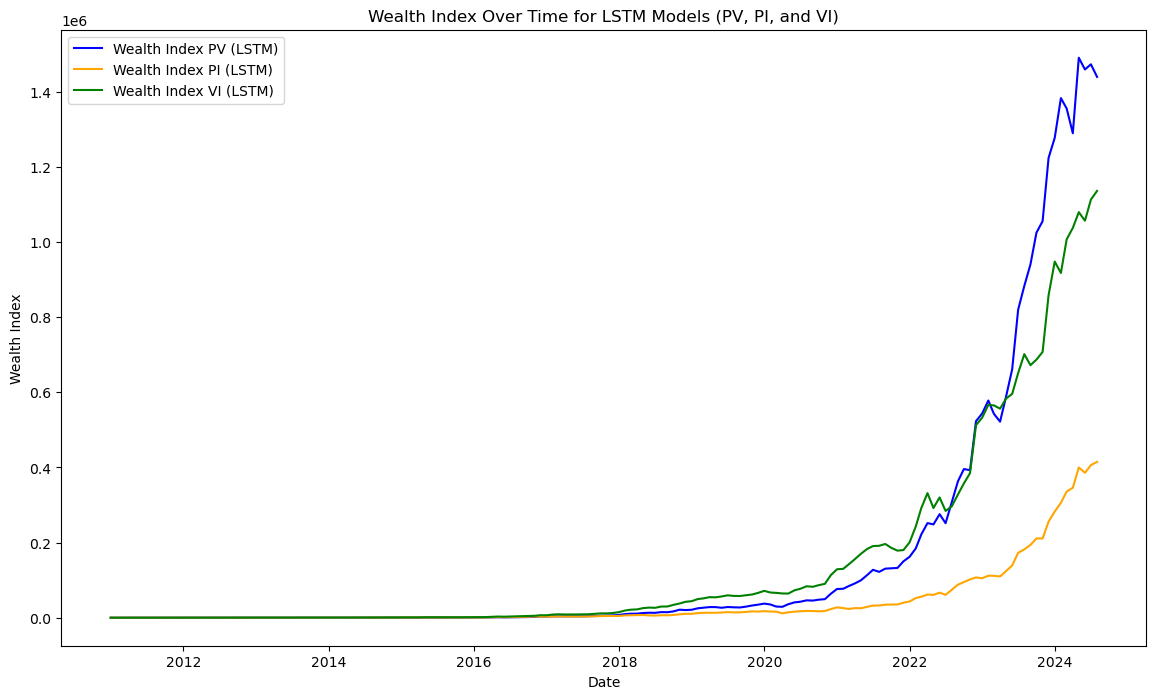

In [263]:
# Display the first few rows to verify
print(WI_l.head())

# Plot the wealth indices
plt.figure(figsize=(14, 8))

plt.plot(WI_l.index, WI_l['Wealth_Index_PV_l'], label='Wealth Index PV (LSTM)', color='blue')
plt.plot(WI_l.index, WI_l['Wealth_Index_PI_l'], label='Wealth Index PI (LSTM)', color='orange')
plt.plot(WI_l.index, WI_l['Wealth_Index_VI_l'], label='Wealth Index VI (LSTM)', color='green')

# Add title and labels
plt.title('Wealth Index Over Time for LSTM Models (PV, PI, and VI)')
plt.xlabel('Date')
plt.ylabel('Wealth Index')
plt.legend()

# Show the plot
plt.show()

In [279]:
# problem with lstm output, as going exponential
#pd.set_option('display.max_rows', None)

# Print the entire Wealth_Index_PV_l series
#print(WI_l['Wealth_Index_PV_l'])

# Reset display options if needed (optional)
#pd.reset_option('display.max_rows')


In [ ]:
# discrepancy between a low R² value and seemingly good error metrics (MAE, RMSE, and MAPE) 
# can be confusing. Here are some potential reasons for this discrepancy:
# Data Characteristics: Time series data often have inherent noise and can be influenced by many factors not included in the model, leading to low R² values. 
# However, the model might still make reasonably accurate predictions, reflected in good MAE, RMSE, and MAPE values.
# Model Fit: The model might capture the general trend and make good short-term predictions but fail to explain the overall variability 
# in the data, resulting in a low R².

In [82]:
# Print the predictions to verify the model exists and can be called on
#print("Predictions for PV:")
#print(predictions_PV)

# Check if the models are stored in variables by printing their summaries
#try:
#    print("PV Model Summary:")
#    print(model_PV.summary())
#except NameError:
#    print("model_PV is not defined")

In [319]:
def predict_ols(x, model):
    print(f"Predicting with input: {x}")
    # Add a constant term for the prediction
    x_with_constant = sm.add_constant([x], has_constant='add')
    print(f"Input with constant added: {x_with_constant}")
    prediction = model.predict(x_with_constant)[0]
    print(f"Generated prediction: {prediction}")
    return prediction

In [320]:
# Define sample inputs for testing
sample_input = [0.5, 1.2, 0.8]  # Replace these values with actual sample inputs relevant to your data

# Test prediction for PV
print("Testing prediction for PV:")
test_prediction_PV = predict_ols(sample_input, model_PV)
print(f"Test Prediction for PV: {test_prediction_PV}")

# Test prediction for PI
print("Testing prediction for PI:")
test_prediction_PI = predict_ols(sample_input, model_PI)
print(f"Test Prediction for PI: {test_prediction_PI}")

# Test prediction for VI
print("Testing prediction for VI:")
test_prediction_VI = predict_ols(sample_input, model_VI)
print(f"Test Prediction for VI: {test_prediction_VI}")


Testing prediction for PV:
Predicting with input: [0.5, 1.2, 0.8]
Input with constant added: [[1.  0.5 1.2 0.8]]
Generated prediction: -0.051026415681893464
Test Prediction for PV: -0.051026415681893464
Testing prediction for PI:
Predicting with input: [0.5, 1.2, 0.8]
Input with constant added: [[1.  0.5 1.2 0.8]]
Generated prediction: 0.03491154289748597
Test Prediction for PI: 0.03491154289748597
Testing prediction for VI:
Predicting with input: [0.5, 1.2, 0.8]
Input with constant added: [[1.  0.5 1.2 0.8]]
Generated prediction: -0.09077035437130031
Test Prediction for VI: -0.09077035437130031


In [137]:
# Assuming predict_ols and the models (model_PV, model_PI, model_VI) are defined elsewhere

def create_forecast_sarimax_widget():
    # Title for the widget
    title = widgets.HTML("<h2>Predict PV, PI, VI using SARIMAX</h2>", layout=widgets.Layout(margin='0 0 0 150px'))

    # Function to update the prediction based on user input
    def update_prediction_ols(y_choice, x1, x2, x3):
        print(f"Updating prediction for {y_choice} with inputs: x1={x1}, x2={x2}, x3={x3}")
        x = np.array([x1, x2, x3])
        if y_choice == 'PV':
            prediction = predict_ols(x, model_PV)
        elif y_choice == 'PI':
            prediction = predict_ols(x, model_PI)
        elif y_choice == 'VI':
            prediction = predict_ols(x, model_VI)
        else:
            prediction = 'Invalid choice'
            print("Invalid choice")
        
        output_ols.clear_output()
        with output_ols:
            print(f"Prediction for next month's {y_choice}: {prediction:.4f}")
    
    # Widgets
    y_options = ['PV', 'PI', 'VI']
    y_selector = widgets.Dropdown(
        options=y_options, 
        description='Select Y:', 
        layout=widgets.Layout(margin='0 0 0 150px'), 
        style={'description_width': 'initial'}
    )

    x1_input = widgets.FloatText(
        description='X1 (Lag of Change of Dependent Variable):', 
        step=0.005, 
        layout=widgets.Layout(margin='0 0 0 150px', width='400px'), 
        style={'description_width': 'initial'}
    )

    x2_input = widgets.FloatText(
        description='X2 (Lag of Change of Bovespa Index):', 
        step=0.005, 
        layout=widgets.Layout(margin='0 0 0 150px', width='400px'), 
        style={'description_width': 'initial'}
    )

    x3_input = widgets.FloatText(
        description='X3 (Lag of Change in Brazilian Loans):', 
        step=0.005, 
        layout=widgets.Layout(margin='0 0 0 150px', width='400px'), 
        style={'description_width': 'initial'}
    )

    submit_button_ols = widgets.Button(
        description='Predict', 
        layout=widgets.Layout(margin='0 0 0 150px')
    )

    output_ols = widgets.Output(
        layout=widgets.Layout(margin='0 0 0 150px')
    )

    # Event handler for the submit button
    def on_submit_button_clicked_ols(b):
        print("Submit button clicked")
        update_prediction_ols(y_selector.value, x1_input.value, x2_input.value, x3_input.value)

    submit_button_ols.on_click(on_submit_button_clicked_ols)

    # Display widgets
    display(title, y_selector, x1_input, x2_input, x3_input, submit_button_ols, output_ols)

# Call the function to create and display the widget
create_forecast_sarimax_widget()

HTML(value='<h2>Predict PV, PI, VI using SARIMAX</h2>', layout=Layout(margin='0 0 0 150px'))

Dropdown(description='Select Y:', layout=Layout(margin='0 0 0 150px'), options=('PV', 'PI', 'VI'), style=Descr…

FloatText(value=0.0, description='X1 (Lag of Change of Dependent Variable):', layout=Layout(margin='0 0 0 150p…

FloatText(value=0.0, description='X2 (Lag of Change of Bovespa Index):', layout=Layout(margin='0 0 0 150px', w…

FloatText(value=0.0, description='X3 (Lag of Change in Brazilian Loans):', layout=Layout(margin='0 0 0 150px',…

Button(description='Predict', layout=Layout(margin='0 0 0 150px'), style=ButtonStyle())

Output(layout=Layout(margin='0 0 0 150px'))

In [309]:
# Save the model_PV to a .pkl file
with open('model_PV.pkl', 'wb') as f:
    pickle.dump(model_PV, f)

# Save the model_PI to a .pkl file
with open('model_PI.pkl', 'wb') as f:
    pickle.dump(model_PI, f)

# Save the model_VI to a .pkl file
with open('model_VI.pkl', 'wb') as f:
    pickle.dump(model_VI, f)

In [314]:
# Define the predictors for PI
predictors_PI = ['BRL_ch_lag1', 'PV_lag1', 'SPY_ch_lag1', 'BOV_ch_lag1', 'br_loans_lag1']
X = combined_df[predictors_PI]
y_PI = combined_df['PI']

# Split the data into training and test sets (e.g., 80% training, 20% testing)
X_train_PI, X_test_PI, y_train_PI, y_test_PI = train_test_split(X, y_PI, test_size=0.2, shuffle=False)

# Scale the training and testing data
scaler = StandardScaler()
X_train_scaled_PI = scaler.fit_transform(X_train_PI)
X_test_scaled_PI = scaler.transform(X_test_PI)

# Define the feature mask for PI (assuming all features are used)
selected_features_mask_PI = [True, True, True, True, True]  # All True since we use all features

# Fit the KNN model for PI
knn_model_PI = KNeighborsRegressor(n_neighbors=3)
knn_model_PI.fit(X_train_scaled_PI[:, selected_features_mask_PI], y_train_PI)

def predict_knn(x, model, scaler, selected_features_mask):
    print(f"Raw input: {x}")
    x_scaled = scaler.transform([x])
    x_scaled_selected = x_scaled[:, selected_features_mask]
    print(f"Scaled input: {x_scaled_selected}")
    prediction = model.predict(x_scaled_selected)[0]
    print(f"Generated prediction: {prediction}")
    return prediction

print("KNN model and scaler are defined and fitted.")

KNN model and scaler are defined and fitted.


In [315]:
def create_knn_prediction_widget_PI():
    # Title for the widget
    title = widgets.HTML("<h2>Predict PI using K-nearest neighbors</h2>", layout=widgets.Layout(margin='0 0 0 150px'))
    
    def update_prediction_knn(x1, x2, x3, x4, x5):
        print(f"Updating prediction with inputs: x1={x1}, x2={x2}, x3={x3}, x4={x4}, x5={x5}")
        x = np.array([x1, x2, x3, x4, x5])
        prediction = predict_knn(x, knn_model_PI, scaler, selected_features_mask_PI)
        
        output_knn.clear_output()
        with output_knn:
            print(f"Prediction: {prediction:.4f}")

    # Widgets
    x1_input = widgets.FloatText(description='BRL_ch_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    x2_input = widgets.FloatText(description='PV_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    x3_input = widgets.FloatText(description='SPY_ch_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    x4_input = widgets.FloatText(description='BOV_ch_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    x5_input = widgets.FloatText(description='br_loans_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    submit_button_knn = widgets.Button(description='Predict', layout=widgets.Layout(margin='0 0 0 150px'))
    output_knn = widgets.Output(layout=widgets.Layout(margin='0 0 0 150px'))

    # Event handler for the submit button
    def on_submit_button_clicked_knn(b):
        print("Submit button clicked")
        update_prediction_knn(x1_input.value, x2_input.value, x3_input.value, x4_input.value, x5_input.value)

    submit_button_knn.on_click(on_submit_button_clicked_knn)

    # Display widgets
    display(title, x1_input, x2_input, x3_input, x4_input, x5_input, submit_button_knn, output_knn)
    print("Widgets are displayed.")

# Call the function to create and display the widget
create_knn_prediction_widget_PI()


HTML(value='<h2>Predict PI using K-nearest neighbors</h2>', layout=Layout(margin='0 0 0 150px'))

FloatText(value=0.0, description='BRL_ch_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.00…

FloatText(value=0.0, description='PV_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.005, s…

FloatText(value=0.0, description='SPY_ch_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.00…

FloatText(value=0.0, description='BOV_ch_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.00…

FloatText(value=0.0, description='br_loans_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.…

Button(description='Predict', layout=Layout(margin='0 0 0 150px'), style=ButtonStyle())

Output(layout=Layout(margin='0 0 0 150px'))

Widgets are displayed.


In [333]:
# Define the predictors for VI
predictors_VI = ['PV_lag1', 'PI_lag1', 'SPY_ch_lag1', 'br_loans_lag1', 'us_ret_mom_lag1']
X = combined_df[predictors_VI]
y_VI = combined_df['VI']

# Split the data into training and test sets (e.g., 80% training, 20% testing)
X_train_VI, X_test_VI, y_train_VI, y_test_VI = train_test_split(X, y_VI, test_size=0.2, shuffle=False)

# Scale the training and testing data
scaler = StandardScaler()
X_train_scaled_VI = scaler.fit_transform(X_train_VI)
X_test_scaled_VI = scaler.transform(X_test_VI)

# Define the feature mask for VI (assuming all features are used)
selected_features_mask_VI = [True, True, True, True, True]  # All True since we use all features

# Fit the KNN model for PI
knn_model_VI = KNeighborsRegressor(n_neighbors=3)
knn_model_VI.fit(X_train_scaled_VI[:, selected_features_mask_VI], y_train_VI)

def predict_knn(x, model, scaler, selected_features_mask):
    print(f"Raw input: {x}")
    x_scaled = scaler.transform([x])
    x_scaled_selected = x_scaled[:, selected_features_mask]
    print(f"Scaled input: {x_scaled_selected}")
    prediction = model.predict(x_scaled_selected)[0]
    print(f"Generated prediction: {prediction}")
    return prediction

print("KNN model and scaler are defined and fitted.")

KNN model and scaler are defined and fitted.


In [334]:
def create_knn_prediction_widget_VI():
    # Title for the widget
    title = widgets.HTML("<h2>Predict VI using K-nearest neighbors</h2>", layout=widgets.Layout(margin='0 0 0 150px'))
    
    def update_prediction_knn(x1, x2, x3, x4, x5):
        print(f"Updating prediction with inputs: x1={x1}, x2={x2}, x3={x3}, x4={x4}, x5={x5}")
        x = np.array([x1, x2, x3, x4, x5])
        prediction = predict_knn(x, knn_model_VI, scaler, selected_features_mask_VI)
        
        output_knn.clear_output()
        with output_knn:
            print(f"Prediction: {prediction:.4f}")

    # Widgets
    x1_input = widgets.FloatText(description='PV_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    x2_input = widgets.FloatText(description='PI_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    x3_input = widgets.FloatText(description='SPY_ch_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    x4_input = widgets.FloatText(description='br_loans_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    x5_input = widgets.FloatText(description='us_ret_mom_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    submit_button_knn = widgets.Button(description='Predict', layout=widgets.Layout(margin='0 0 0 150px'))
    output_knn = widgets.Output(layout=widgets.Layout(margin='0 0 0 150px'))

    # Event handler for the submit button
    def on_submit_button_clicked_knn(b):
        print("Submit button clicked")
        update_prediction_knn(x1_input.value, x2_input.value, x3_input.value, x4_input.value, x5_input.value)

    submit_button_knn.on_click(on_submit_button_clicked_knn)

    # Display widgets
    display(title, x1_input, x2_input, x3_input, x4_input, x5_input, submit_button_knn, output_knn)
    print("Widgets are displayed.")

# Call the function to create and display the widget
create_knn_prediction_widget_VI()


HTML(value='<h2>Predict VI using K-nearest neighbors</h2>', layout=Layout(margin='0 0 0 150px'))

FloatText(value=0.0, description='PV_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.005, s…

FloatText(value=0.0, description='PI_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.005, s…

FloatText(value=0.0, description='SPY_ch_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.00…

FloatText(value=0.0, description='br_loans_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.…

FloatText(value=0.0, description='us_ret_mom_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=…

Button(description='Predict', layout=Layout(margin='0 0 0 150px'), style=ButtonStyle())

Output(layout=Layout(margin='0 0 0 150px'))

Widgets are displayed.


In [ ]:
Selected features for PV_k: ['PI_lag1' 'VI_lag1' 'BOV_ch_lag1' 'SPY_ch_lag1' 'br_loans_lag1']
Selected features for PI_k: ['PV_lag1' 'BRL_ch_lag1' 'BOV_ch_lag1' 'SPY_ch_lag1' 'br_loans_lag1']
Selected features for VI_k: ['PV_lag1' 'PI_lag1' 'SPY_ch_lag1' 'br_loans_lag1' 'us_ret_mom_lag1']

In [327]:
# Define the predictors for PV
predictors_PV = ['PI_lag1', 'VI_lag1', 'BOV_ch_lag1', 'SPY_ch_lag1', 'br_loans_lag1']
X = combined_df[predictors_PV]
y_PV = combined_df['PV']

# Split the data into training and test sets (e.g., 80% training, 20% testing)
X_train_PV, X_test_PV, y_train_PV, y_test_PV = train_test_split(X, y_PV, test_size=0.2, shuffle=False)

# Scale the training and testing data
scaler = StandardScaler()
X_train_scaled_PV = scaler.fit_transform(X_train_PV)
X_test_scaled_PV = scaler.transform(X_test_PV)

# Define the feature mask for PV (assuming all features are used)
selected_features_mask_PV = [True, True, True, True, True]  # All True since we use all features

# Fit the KNN model for PV
knn_model_PV = KNeighborsRegressor(n_neighbors=3)
knn_model_PV.fit(X_train_scaled_PV[:, selected_features_mask_PV], y_train_PV)

def predict_knn(x, model, scaler, selected_features_mask):
    print(f"Raw input: {x}")
    x_scaled = scaler.transform([x])
    x_scaled_selected = x_scaled[:, selected_features_mask]
    print(f"Scaled input: {x_scaled_selected}")
    prediction = model.predict(x_scaled_selected)[0]
    print(f"Generated prediction: {prediction}")
    return prediction

print("KNN model and scaler are defined and fitted.")

KNN model and scaler are defined and fitted.


In [328]:
def create_knn_prediction_widget_PV():
    # Title for the widget
    title = widgets.HTML("<h2>Predict PV using K-nearest neighbors</h2>", layout=widgets.Layout(margin='0 0 0 150px'))
    
    def update_prediction_knn(x1, x2, x3, x4, x5):
        print(f"Updating prediction with inputs: x1={x1}, x2={x2}, x3={x3}, x4={x4}, x5={x5}")
        x = np.array([x1, x2, x3, x4, x5])
        prediction = predict_knn(x, knn_model_PV, scaler, selected_features_mask_PV)
        
        output_knn.clear_output()
        with output_knn:
            print(f"Prediction: {prediction:.4f}")

    # Widgets
    x1_input = widgets.FloatText(description='PI_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    x2_input = widgets.FloatText(description='VI_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    x3_input = widgets.FloatText(description='BOV_ch_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    x4_input = widgets.FloatText(description='SPY_ch_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    x5_input = widgets.FloatText(description='br_loans_lag1:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
    submit_button_knn = widgets.Button(description='Predict', layout=widgets.Layout(margin='0 0 0 150px'))
    output_knn = widgets.Output(layout=widgets.Layout(margin='0 0 0 150px'))

    # Event handler for the submit button
    def on_submit_button_clicked_knn(b):
        print("Submit button clicked")
        update_prediction_knn(x1_input.value, x2_input.value, x3_input.value, x4_input.value, x5_input.value)

    submit_button_knn.on_click(on_submit_button_clicked_knn)

    # Display widgets
    display(title, x1_input, x2_input, x3_input, x4_input, x5_input, submit_button_knn, output_knn)
    print("Widgets are displayed.")

# Call the function to create and display the widget
create_knn_prediction_widget_PV()


HTML(value='<h2>Predict PV using K-nearest neighbors</h2>', layout=Layout(margin='0 0 0 150px'))

FloatText(value=0.0, description='PI_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.005, s…

FloatText(value=0.0, description='VI_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.005, s…

FloatText(value=0.0, description='BOV_ch_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.00…

FloatText(value=0.0, description='SPY_ch_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.00…

FloatText(value=0.0, description='br_loans_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.…

Button(description='Predict', layout=Layout(margin='0 0 0 150px'), style=ButtonStyle())

Output(layout=Layout(margin='0 0 0 150px'))

Widgets are displayed.


In [329]:
# Save the KNN model to a .pkl file
with open('knn_model_PV.pkl', 'wb') as f:
    pickle.dump(knn_model_PV, f)
with open('knn_model_PI.pkl', 'wb') as f:
    pickle.dump(knn_model_PI, f)
with open('knn_model_VI.pkl', 'wb') as f:
    pickle.dump(knn_model_VI, f)

In [336]:
import joblib

# Save the feature mask used for training the KNN model
joblib.dump(features_mask_PV, 'features_mask_PV.pkl')
joblib.dump(features_mask_PI, 'features_mask_PI.pkl')
joblib.dump(features_mask_VI, 'features_mask_VI.pkl')

['features_mask_VI.pkl']

In [144]:
# Define the predictors for PV (provided lagged variables)
lagged_predictors_PV = [
    'PI_lag1', 'SPY_ch_lag1', 'br_loans_lag1', 'BOV_ch_lag1', 'VI_lag1',
    'us_nom5yr_lag1', 'BRL_ch_lag1', 'ch_loans_lag1', 'br_ip_mom_lag1',
    'br_conconf_lag1', 'PV_lag1', 'us_ret_mom_lag1', 'br_fdi_lag1', 'br_yld_lag1',
    'br_ret_mom_lag1'
]
X = combined_df[lagged_predictors_PV]
y_PV = combined_df['PV']

# Split the data into training and test sets (e.g., 80% training, 20% testing)
X_train_PV, X_test_PV, y_train_PV, y_test_PV = train_test_split(X, y_PV, test_size=0.2, shuffle=False)

# Scale the training and testing data
scaler = StandardScaler()
X_train_scaled_PV = scaler.fit_transform(X_train_PV)
X_test_scaled_PV = scaler.transform(X_test_PV)

# Reshape the data for LSTM [samples, time steps, features]
X_train_scaled_PV = X_train_scaled_PV.reshape((X_train_scaled_PV.shape[0], 1, X_train_scaled_PV.shape[1]))
X_test_scaled_PV = X_test_scaled_PV.reshape((X_test_scaled_PV.shape[0], 1, X_test_scaled_PV.shape[1]))

# Fit the LSTM model for PV
model_PV = Sequential()
model_PV.add(LSTM(50, activation='relu', input_shape=(X_train_scaled_PV.shape[1], X_train_scaled_PV.shape[2])))
model_PV.add(Dense(1))
model_PV.compile(optimizer='adam', loss='mse')
model_PV.fit(X_train_scaled_PV, y_train_PV, epochs=200, batch_size=32, verbose=0)

def predict_lstm(x, model, scaler):
    print(f"Raw input: {x}")
    x_scaled = scaler.transform([x])
    x_scaled_reshaped = x_scaled.reshape((x_scaled.shape[0], 1, x_scaled.shape[1]))
    print(f"Scaled input: {x_scaled_reshaped}")
    prediction = model.predict(x_scaled_reshaped)[0]
    print(f"Generated prediction: {prediction}")
    return float(prediction)  # Ensure the prediction is converted to a float

print("LSTM model and scaler are defined and fitted.")

LSTM model and scaler are defined and fitted.


In [57]:
def create_lstm_prediction_widget_PV():
    # Title for the widget
    title = widgets.HTML("<h2>Predict PV using LSTM</h2>", layout=widgets.Layout(margin='0 0 0 150px'))
    
    # Function to update the prediction based on user input
    def update_prediction_lstm(*inputs):
        print(f"Updating prediction with inputs: {inputs}")
        x = np.array(inputs)
        prediction = predict_lstm(x, model_PV, scaler)
        
        output_lstm.clear_output()
        with output_lstm:
            print(f"Prediction: {prediction:.4f}")

    # Creating input widgets for each predictor
    input_widgets = []
    for predictor in lagged_predictors_PV:
        input_widgets.append(
            widgets.FloatText(description=f'{predictor}:', step=0.005, layout=widgets.Layout(margin='0 0 0 150px', width='400px'), style={'description_width': 'initial'})
        )

    submit_button_lstm = widgets.Button(description='Predict', layout=widgets.Layout(margin='0 0 0 150px'))
    output_lstm = widgets.Output(layout=widgets.Layout(margin='0 0 0 150px'))

    # Event handler for the submit button
    def on_submit_button_clicked_lstm(b):
        print("Submit button clicked")
        input_values = [widget.value for widget in input_widgets]
        update_prediction_lstm(*input_values)

    submit_button_lstm.on_click(on_submit_button_clicked_lstm)

    # Display widgets
    display(title, *input_widgets, submit_button_lstm, output_lstm)
    print("Widgets are displayed.")

# Call the function to create and display the widget
create_lstm_prediction_widget_PV()


HTML(value='<h2>Predict PV using LSTM</h2>', layout=Layout(margin='0 0 0 150px'))

FloatText(value=0.0, description='PI_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.005, s…

FloatText(value=0.0, description='SPY_ch_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.00…

FloatText(value=0.0, description='br_loans_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.…

FloatText(value=0.0, description='BOV_ch_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.00…

FloatText(value=0.0, description='VI_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.005, s…

FloatText(value=0.0, description='us_nom5yr_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0…

FloatText(value=0.0, description='BRL_ch_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.00…

FloatText(value=0.0, description='ch_loans_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.…

FloatText(value=0.0, description='br_ip_mom_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0…

FloatText(value=0.0, description='br_conconf_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=…

FloatText(value=0.0, description='PV_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.005, s…

FloatText(value=0.0, description='us_ret_mom_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=…

FloatText(value=0.0, description='br_fdi_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.00…

FloatText(value=0.0, description='br_yld_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=0.00…

FloatText(value=0.0, description='br_ret_mom_lag1:', layout=Layout(margin='0 0 0 150px', width='400px'), step=…

Button(description='Predict', layout=Layout(margin='0 0 0 150px'), style=ButtonStyle())

Output(layout=Layout(margin='0 0 0 150px'))

Widgets are displayed.


In [264]:
#generate comparative return graphs: naive 50/50 vs select strategies
# Check the length of rfe.ranking_ and the shape of X_train_scaled
print(f"Length of rfe_PV.ranking_: {len(rfe_PV.ranking_)}")
print(f"Number of features in X_train_scaled: {X_train_scaled.shape[1]}")

# Check if they match
if len(rfe_PV.ranking_) != X_train_scaled.shape[1]:
    print("Mismatch detected. Adjusting feature selection process.")
else:
    print("Feature selection process is aligned.")


Length of rfe_PV.ranking_: 15
Number of features in X_train_scaled: 15
Feature selection process is aligned.


In [265]:
# Define the start and end dates
start_date = '2011-01-31'
end_date = '2024-06-30'

# Adjust the returns series to match the date range
petr3_returns = df_pr_wi_m['PETR3'].truncate(before=start_date, after=end_date)
vale3_returns = df_pr_wi_m['VALE3'].truncate(before=start_date, after=end_date)
itub4_returns = df_pr_wi_m['ITUB4'].truncate(before=start_date, after=end_date)

# Ensure the predictions have the same datetime index as the combined_df
predictions_PV_s = pd.Series(predictions_PV, index=combined_df.index[:len(predictions_PV)]).truncate(before=start_date, after=end_date)
predictions_PV_k = pd.Series(knn_predictions_PV, index=combined_df.index[:len(knn_predictions_PV)]).truncate(before=start_date, after=end_date)
predictions_PV_l = pd.Series(lstm_predictions_PV, index=combined_df.index[:len(lstm_predictions_PV)]).truncate(before=start_date, after=end_date)

# Verify lengths after adjustment
print(f"Adjusted Length of PETR3 returns: {len(petr3_returns)}")
print(f"Adjusted Length of VALE3 returns: {len(vale3_returns)}")
print(f"Adjusted Length of ITUB4 returns: {len(itub4_returns)}")
print(f"Adjusted Length of predictions_PV_s: {len(predictions_PV_s)}")
print(f"Adjusted Length of predictions_PV_k: {len(predictions_PV_k)}")
print(f"Adjusted Length of predictions_PV_l: {len(predictions_PV_l)}")

# Ensure all series have the same length and the same dates
common_dates = petr3_returns.index.intersection(predictions_PV_s.index).intersection(predictions_PV_k.index).intersection(predictions_PV_l.index)

petr3_returns = petr3_returns.loc[common_dates]
vale3_returns = vale3_returns.loc[common_dates]
itub4_returns = itub4_returns.loc[common_dates]
predictions_PV_s = predictions_PV_s.loc[common_dates]
predictions_PV_k = predictions_PV_k.loc[common_dates]
predictions_PV_l = predictions_PV_l.loc[common_dates]

# Verify lengths after ensuring common dates
print(f"Common Length of PETR3 returns: {len(petr3_returns)}")
print(f"Common Length of VALE3 returns: {len(vale3_returns)}")
print(f"Common Length of ITUB4 returns: {len(itub4_returns)}")
print(f"Common Length of predictions_PV_s: {len(predictions_PV_s)}")
print(f"Common Length of predictions_PV_k: {len(predictions_PV_k)}")
print(f"Common Length of predictions_PV_l: {len(predictions_PV_l)}")

# Ensure the indices and lengths are correct before proceeding
assert len(petr3_returns) == len(vale3_returns) == len(itub4_returns) == len(predictions_PV_s) == len(predictions_PV_k) == len(predictions_PV_l), "Lengths of series do not match!"

# Print final verification
print("All series are aligned and ready for further analysis.")


Adjusted Length of PETR3 returns: 162
Adjusted Length of VALE3 returns: 162
Adjusted Length of ITUB4 returns: 162
Adjusted Length of predictions_PV_s: 162
Adjusted Length of predictions_PV_k: 162
Adjusted Length of predictions_PV_l: 162
Common Length of PETR3 returns: 162
Common Length of VALE3 returns: 162
Common Length of ITUB4 returns: 162
Common Length of predictions_PV_s: 162
Common Length of predictions_PV_k: 162
Common Length of predictions_PV_l: 162
All series are aligned and ready for further analysis.


In [192]:
# Calculate portfolio returns
portfolio_returns = 0.5 * petr3_returns + 0.5 * vale3_returns
portfolio_returns_PI = 0.5 * petr3_returns + 0.5 * itub4_returns
portfolio_returns_VI = 0.5 * vale3_returns + 0.5 * itub4_returns

# Function to generate wealth index from returns
def generate_wealth_index(returns, initial_wealth=100):
    cumulative_returns = (returns + 1).cumprod()
    wealth_index = initial_wealth * cumulative_returns
    return wealth_index

# Generate wealth index for the portfolio PV, PI, VI
initial_wealth = 100  # Starting portfolio value
wealth_index_portfolio_PV = generate_wealth_index(portfolio_returns, initial_wealth)

# Create a DataFrame to store the wealth index
wealth_df_PV = pd.DataFrame({
    'Ret_PV': portfolio_returns,
    'WI_PV': wealth_index_portfolio_PV
})


# Generate wealth index for the portfolio PI
initial_wealth = 100  # Starting portfolio value
wealth_index_portfolio_PI = generate_wealth_index(portfolio_returns_PI, initial_wealth)

# Create a DataFrame to store the wealth index
wealth_df_PI = pd.DataFrame({
    'Ret_PI': portfolio_returns,
    'WI_PI': wealth_index_portfolio_PI
})

# Generate wealth index for the portfolio VI
initial_wealth = 100  # Starting portfolio value
wealth_index_portfolio_VI = generate_wealth_index(portfolio_returns_VI, initial_wealth)

# Create a DataFrame to store the wealth index
wealth_df_VI = pd.DataFrame({
    'Ret_VI': portfolio_returns,
    'WI_VI': wealth_index_portfolio_VI
})

# Display the first few rows to verify
print(wealth_df_PV.head())
print(wealth_df_PI.head())
print(wealth_df_VI.head())

            Ret_PV    WI_PV
2011-01-31  0.0162 101.6194
2011-02-28  0.0356 105.2369
2011-03-31 -0.0243 102.6748
2011-04-30 -0.0238 100.2275
2011-05-31 -0.0470  95.5118
            Ret_PI    WI_PI
2011-01-31  0.0162  94.7167
2011-02-28  0.0356 100.6281
2011-03-31 -0.0243 105.9061
2011-04-30 -0.0238 101.7257
2011-05-31 -0.0470  96.7406
            Ret_VI   WI_VI
2011-01-31  0.0162 97.5119
2011-02-28  0.0356 98.7940
2011-03-31 -0.0243 98.0884
2011-04-30 -0.0238 98.3548
2011-05-31 -0.0470 95.2379


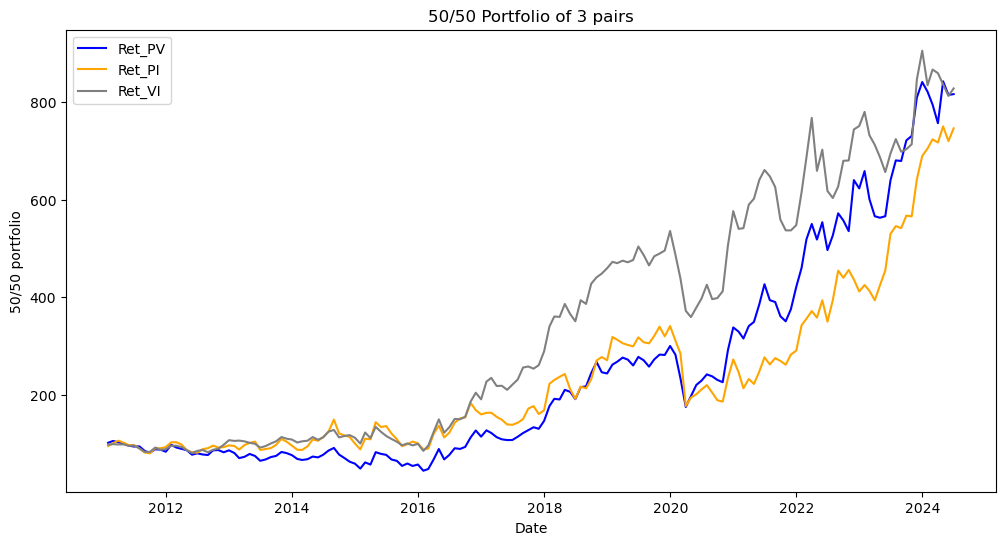

In [266]:
# Plot the wealth index
plt.figure(figsize=(12, 6))
plt.plot(wealth_df_PV.index, wealth_df_PV['WI_PV'], label='Ret_PV', color='blue')
plt.plot(wealth_df_PI.index, wealth_df_PI['WI_PI'], label='Ret_PI', color='orange')
plt.plot(wealth_df_VI.index, wealth_df_VI['WI_VI'], label='Ret_VI', color='grey')
# Add title and labels
plt.title('50/50 Portfolio of 3 pairs')
plt.xlabel('Date')
plt.ylabel('50/50 portfolio')
plt.legend()

# Show the plot
plt.show()

In [271]:
# Ensure the portfolio wealth indices are correctly named in the wealth_df_PV, wealth_df_PI, and wealth_df_VI DataFrames
wealth_df_PV = pd.DataFrame({'Wealth_Index_Portfolio': wealth_index_portfolio_PV})
wealth_df_PI = pd.DataFrame({'Wealth_Index_Portfolio': wealth_index_portfolio_PI})
wealth_df_VI = pd.DataFrame({'Wealth_Index_Portfolio': wealth_index_portfolio_VI})

In [275]:
# Combine wealth indices for PV
combined_wealth_PV = pd.concat([
    WI_s['Wealth_Index_PV'],
    WI_k['Wealth_Index_PV_k'],
    WI_l['Wealth_Index_PV_l'],
    wealth_df_PV['Wealth_Index_Portfolio']
], axis=1).dropna()

combined_wealth_PV.columns = ['Wealth_Index_PV_OLS', 'Wealth_Index_PV_KNN', 'Wealth_Index_PV_LSTM', 'Wealth_Index_PV_Portfolio']

# Combine wealth indices for PI
combined_wealth_PI = pd.concat([
    WI_s['Wealth_Index_PI'],
    WI_k['Wealth_Index_PI_k'],
    WI_l['Wealth_Index_PI_l'],
    wealth_df_PI['Wealth_Index_Portfolio']
], axis=1).dropna()

combined_wealth_PI.columns = ['Wealth_Index_PI_OLS', 'Wealth_Index_PI_KNN', 'Wealth_Index_PI_LSTM', 'Wealth_Index_PI_Portfolio']

# Combine wealth indices for VI
combined_wealth_VI = pd.concat([
    WI_s['Wealth_Index_VI'],
    WI_k['Wealth_Index_VI_k'],
    WI_l['Wealth_Index_VI_l'],
    wealth_df_VI['Wealth_Index_Portfolio']
], axis=1).dropna()

combined_wealth_VI.columns = ['Wealth_Index_VI_OLS', 'Wealth_Index_VI_KNN', 'Wealth_Index_VI_LSTM', 'Wealth_Index_VI_Portfolio']

# Print the combined dataframes
print("Combined Wealth Indices for PV:")
print(combined_wealth_PV.head())

print("\nCombined Wealth Indices for PI:")
print(combined_wealth_PI.head())

print("\nCombined Wealth Indices for VI:")
print(combined_wealth_VI.head())

Combined Wealth Indices for PV:
            Wealth_Index_PV_OLS  Wealth_Index_PV_KNN  Wealth_Index_PV_LSTM  \
2011-01-31              97.2351              99.0837              104.4146   
2011-02-28              95.6398              97.7297              110.1577   
2011-03-31              95.7818              98.8319              111.4001   
2011-04-30              93.3450             100.6459              113.4447   
2011-05-31              92.6179              97.6532              107.6548   

            Wealth_Index_PV_Portfolio  
2011-01-31                   101.6194  
2011-02-28                   105.2369  
2011-03-31                   102.6748  
2011-04-30                   100.2275  
2011-05-31                    95.5118  

Combined Wealth Indices for PI:
            Wealth_Index_PI_OLS  Wealth_Index_PI_KNN  Wealth_Index_PI_LSTM  \
2011-01-31              99.6972              99.0837               99.0837   
2011-02-28              99.2706              97.7297              104.

In [276]:
# Assuming the wealth indices DataFrames are as follows:
# WI_s for OLS
# WI_k_combined for KNN
# WI_l for LSTM
# wealth_df_PV for the 50/50 portfolio

# Extracting the PV series from each DataFrame
wealth_index_PV_ols = WI_s['Wealth_Index_PV']
wealth_index_PV_knn = WI_k_combined['Wealth_Index_PV_k']
wealth_index_PV_lstm = WI_l['Wealth_Index_PV_l']
wealth_index_portfolio = wealth_df_PV['Wealth_Index_Portfolio']

# Combine the PV wealth indices into a single DataFrame
combined_PV_wealth_df = pd.DataFrame({
    'Wealth_Index_PV_OLS': wealth_index_PV_ols,
    'Wealth_Index_PV_KNN': wealth_index_PV_knn,
    'Wealth_Index_PV_LSTM': wealth_index_PV_lstm,
    'Wealth_Index_Portfolio': wealth_index_portfolio
})

# Display the first few rows to verify
print(combined_PV_wealth_df.head())

print(combined_wealth_PI.head())

print(combined_wealth_VI.head())

            Wealth_Index_PV_OLS  Wealth_Index_PV_KNN  Wealth_Index_PV_LSTM  \
2010-12-31                  NaN                  NaN              100.0000   
2011-01-31              97.2351             103.3753              104.4146   
2011-02-28              95.6398             110.7399              110.1577   
2011-03-31              95.7818             122.5332              111.4001   
2011-04-30              93.3450             120.2972              113.4447   

            Wealth_Index_Portfolio  
2010-12-31                     NaN  
2011-01-31                101.6194  
2011-02-28                105.2369  
2011-03-31                102.6748  
2011-04-30                100.2275  

Combined Wealth Indices for PI:
            Wealth_Index_PI_OLS  Wealth_Index_PI_KNN  Wealth_Index_PI_LSTM  \
2011-01-31              99.6972              99.0837               99.0837   
2011-02-28              99.2706              97.7297              104.5336   
2011-03-31             100.8921           

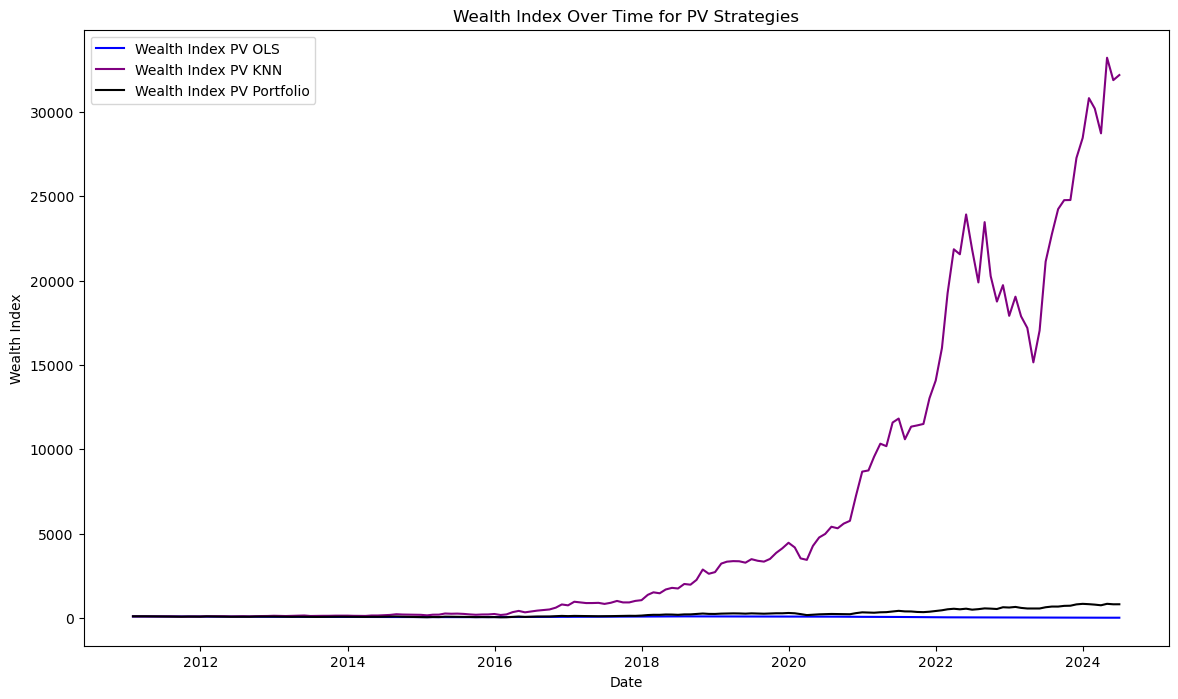

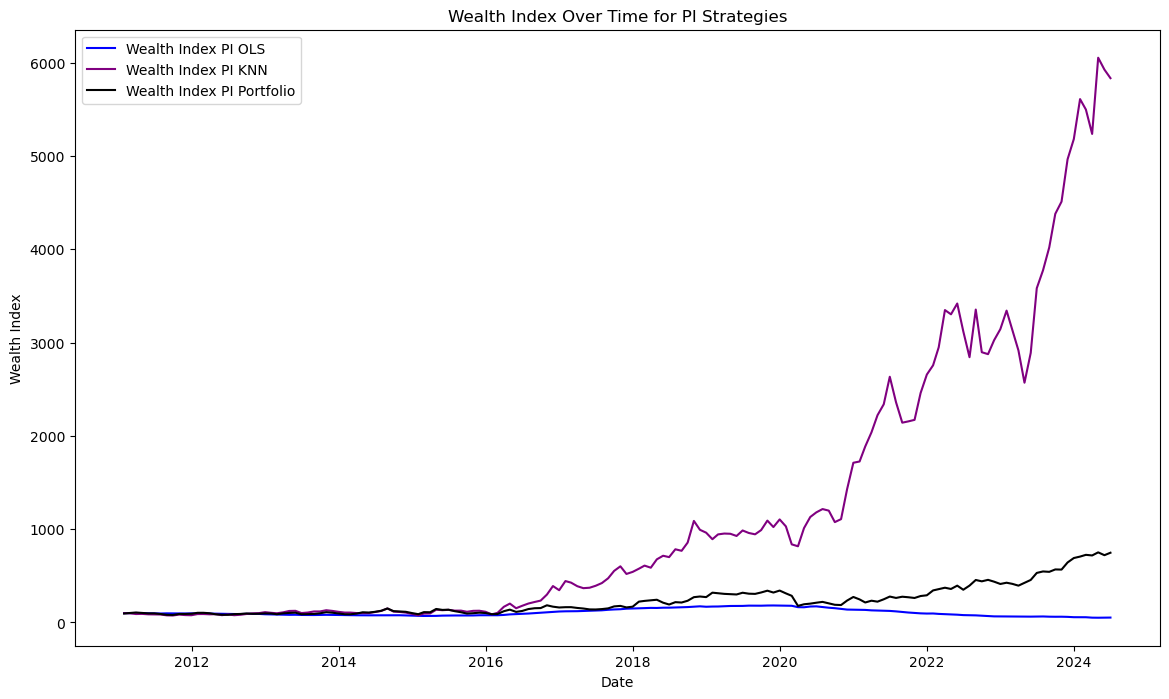

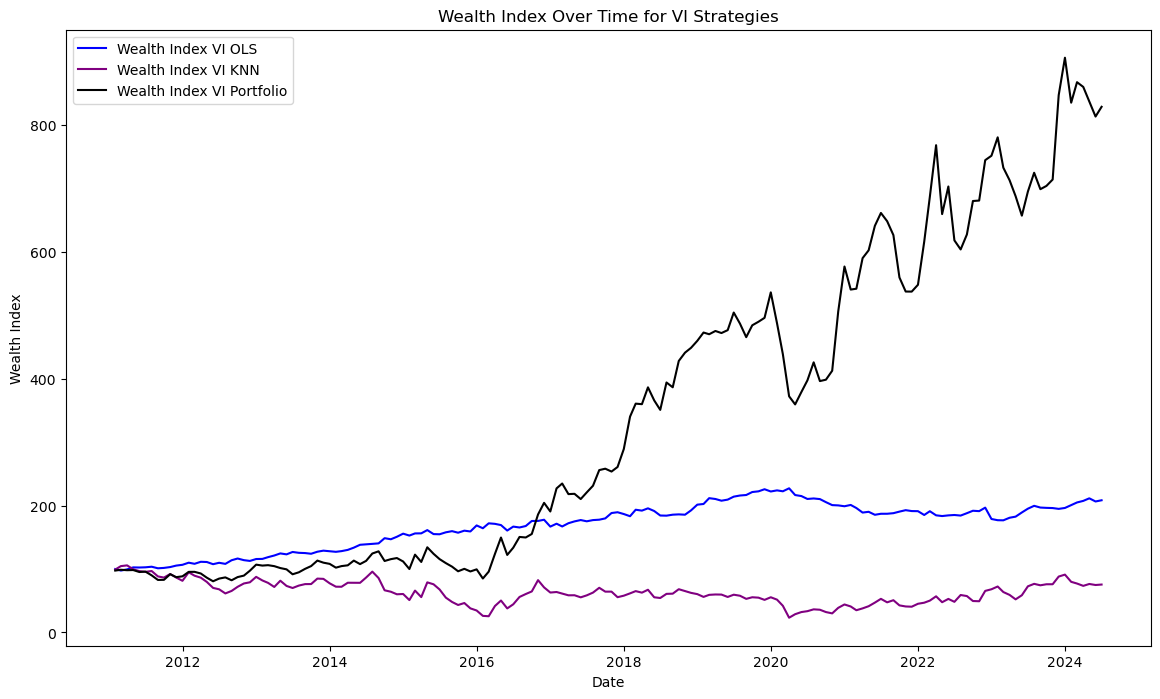

In [281]:
# Plot for PV
plt.figure(figsize=(14, 8))
plt.plot(combined_wealth_PV.index, combined_wealth_PV['Wealth_Index_PV_OLS'], label='Wealth Index PV OLS', color='blue')
plt.plot(combined_wealth_PV.index, combined_wealth_PV['Wealth_Index_PV_KNN'], label='Wealth Index PV KNN', color='purple')
#plt.plot(combined_wealth_PV.index, combined_wealth_PV['Wealth_Index_PV_LSTM'], label='Wealth Index PV LSTM', color='green')
plt.plot(combined_wealth_PV.index, combined_wealth_PV['Wealth_Index_PV_Portfolio'], label='Wealth Index PV Portfolio', color='black')
plt.title('Wealth Index Over Time for PV Strategies')
plt.xlabel('Date')
plt.ylabel('Wealth Index')
plt.legend()
plt.show()

# Plot for PI
plt.figure(figsize=(14, 8))
plt.plot(combined_wealth_PI.index, combined_wealth_PI['Wealth_Index_PI_OLS'], label='Wealth Index PI OLS', color='blue')
plt.plot(combined_wealth_PI.index, combined_wealth_PI['Wealth_Index_PI_KNN'], label='Wealth Index PI KNN', color='purple')
#plt.plot(combined_wealth_PI.index, combined_wealth_PI['Wealth_Index_PI_LSTM'], label='Wealth Index PI LSTM', color='green')
plt.plot(combined_wealth_PI.index, combined_wealth_PI['Wealth_Index_PI_Portfolio'], label='Wealth Index PI Portfolio', color='black')
plt.title('Wealth Index Over Time for PI Strategies')
plt.xlabel('Date')
plt.ylabel('Wealth Index')
plt.legend()
plt.show()

# Plot for VI
plt.figure(figsize=(14, 8))
plt.plot(combined_wealth_VI.index, combined_wealth_VI['Wealth_Index_VI_OLS'], label='Wealth Index VI OLS', color='blue')
plt.plot(combined_wealth_VI.index, combined_wealth_VI['Wealth_Index_VI_KNN'], label='Wealth Index VI KNN', color='purple')
#plt.plot(combined_wealth_VI.index, combined_wealth_VI['Wealth_Index_VI_LSTM'], label='Wealth Index VI LSTM', color='green')
plt.plot(combined_wealth_VI.index, combined_wealth_VI['Wealth_Index_VI_Portfolio'], label='Wealth Index VI Portfolio', color='black')
plt.title('Wealth Index Over Time for VI Strategies')
plt.xlabel('Date')
plt.ylabel('Wealth Index')
plt.legend()
plt.show()


In [347]:
combined_wealth_PV.to_csv('combined_wealth_PV.csv', index=True)
combined_wealth_PI.to_csv('combined_wealth_PI.csv', index=True)
combined_wealth_VI.to_csv('combined_wealth_VI.csv', index=True)

In [287]:
def calculate_statistics(wealth_index):
    # Calculate monthly returns
    returns = wealth_index.pct_change().dropna()
    
    # Total return
    total_return = (wealth_index.iloc[-1] / wealth_index.iloc[0]) - 1
    
    # Average monthly return
    avg_monthly_return = returns.mean()
    
    # Volatility (standard deviation of returns)
    volatility = returns.std()
    
    # Sharpe ratio (assuming risk-free rate is 0)
    sharpe_ratio = (avg_monthly_return / volatility) * np.sqrt(12)  # Annualized Sharpe ratio
    
    return total_return, avg_monthly_return, volatility, sharpe_ratio

# Calculate statistics for 50/50 portfolio, SARIMAX (OLS), and KNN for PV
stats_portfolio_PV = calculate_statistics(wealth_df_PV['Wealth_Index_Portfolio'])
stats_OLS_PV = calculate_statistics(WI_s['Wealth_Index_PV'])
stats_KNN_PV = calculate_statistics(WI_k['Wealth_Index_PV_k'])

# Create a DataFrame to store the results
stats_df_PV = pd.DataFrame({
    'Model': ['50/50 Portfolio', 'SARIMAX (OLS)', 'KNN'],
    'Total Return': [stats_portfolio_PV[0], stats_OLS_PV[0], stats_KNN_PV[0]],
    'Avg Monthly Ret': [stats_portfolio_PV[1], stats_OLS_PV[1], stats_KNN_PV[1]],
    'Volatility': [stats_portfolio_PV[2], stats_OLS_PV[2], stats_KNN_PV[2]],
    'Sharpe Ratio': [stats_portfolio_PV[3], stats_OLS_PV[3], stats_KNN_PV[3]]
})

# Print the DataFrame
print("Statistics for PV Strategies:")
print(stats_df_PV)

# Repeat the process for PI and VI if needed
stats_portfolio_PI = calculate_statistics(wealth_df_PI['Wealth_Index_Portfolio'])
stats_OLS_PI = calculate_statistics(WI_s['Wealth_Index_PI'])
stats_KNN_PI = calculate_statistics(WI_k['Wealth_Index_PI_k'])

stats_df_PI = pd.DataFrame({
    'Model': ['50/50 Portfolio', 'SARIMAX (OLS)', 'KNN'],
    'Total Return': [stats_portfolio_PI[0], stats_OLS_PI[0], stats_KNN_PI[0]],
    'Avg Monthly Ret': [stats_portfolio_PI[1], stats_OLS_PI[1], stats_KNN_PI[1]],
    'Volatility': [stats_portfolio_PI[2], stats_OLS_PI[2], stats_KNN_PI[2]],
    'Sharpe Ratio': [stats_portfolio_PI[3], stats_OLS_PI[3], stats_KNN_PI[3]]
})

print("\nStatistics for PI Strategies:")
print(stats_df_PI)

stats_portfolio_VI = calculate_statistics(wealth_df_VI['Wealth_Index_Portfolio'])
stats_OLS_VI = calculate_statistics(WI_s['Wealth_Index_VI'])
stats_KNN_VI = calculate_statistics(WI_k['Wealth_Index_VI_k'])

stats_df_VI = pd.DataFrame({
    'Model': ['50/50 Portfolio', 'SARIMAX (OLS)', 'KNN'],
    'Total Return': [stats_portfolio_VI[0], stats_OLS_VI[0], stats_KNN_VI[0]],
    'Avg Monthly Ret': [stats_portfolio_VI[1], stats_OLS_VI[1], stats_KNN_VI[1]],
    'Volatility': [stats_portfolio_VI[2], stats_OLS_VI[2], stats_KNN_VI[2]],
    'Sharpe Ratio': [stats_portfolio_VI[3], stats_OLS_VI[3], stats_KNN_VI[3]]
})

print("\nStatistics for VI Strategies:")
print(stats_df_VI)


Statistics for PV Strategies:
             Model  Total Return  Avg Monthly Ret  Volatility  Sharpe Ratio
0  50/50 Portfolio        7.0384           0.0182      0.1043        0.6037
1    SARIMAX (OLS)       -0.7999          -0.0097      0.0233       -1.4393
2              KNN      313.5189           0.0419      0.1148        1.2644

Statistics for PI Strategies:
             Model  Total Return  Avg Monthly Ret  Volatility  Sharpe Ratio
0  50/50 Portfolio        6.8834           0.0177      0.0992        0.6195
1    SARIMAX (OLS)       -0.4822          -0.0037      0.0263       -0.4920
2              KNN       60.3730           0.0322      0.1196        0.9316

Statistics for VI Strategies:
             Model  Total Return  Avg Monthly Ret  Volatility  Sharpe Ratio
0  50/50 Portfolio        7.4968           0.0164      0.0791        0.7175
1    SARIMAX (OLS)        1.0855           0.0048      0.0233        0.7200
2              KNN       -0.2623           0.0060      0.1280        0.1

In [308]:
# Define the mapping
model_name_map = {
    'PV_s': 'PV-SARIMAX',
    'PV_k': 'PV-KNN',
    'PV_l': 'PV-LSTM',
    'PI_s': 'PI-SARIMAX',
    'PI_k': 'PI-KNN',
    'PI_l': 'PI-LSTM',
    'VI_s': 'VI-SARIMAX',
    'VI_k': 'VI-KNN',
    'VI_l': 'VI-LSTM'
}

# Apply the mapping to create the new DataFrame
test_comp_sl = test_comp.copy()
test_comp_sl['Model'] = test_comp_sl['Model'].map(model_name_map)

# Save the updated DataFrame to a CSV file
test_comp_sl.to_csv('test_comp_stats.csv', index=False)


In [ ]:
#run streamlit app
# Replace 'your_script.py' with the name of your Streamlit application file
#script_name = 'testweb.py'

# Use subprocess to run the command
#subprocess.run(['streamlit', 'run', script_name])
